In [1]:
import os
import shutil

In [2]:
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, ticker
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
DATA_FILEPATH = "resources/2016_Building_Energy_Benchmarking.csv"

In [4]:
TARGET_COLUMN = "SiteEUIWN(kBtu/sf)"
TARGET_COLUMN2 = "GHGEmissionsIntensity"

STRUCTURAL_DATA_COLUMNS

In [5]:
CONSIDERED_COLUMNS = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode",
                      "ComplianceStatus", "Latitude", "Longitude", "YearBuilt", "NumberofBuildings", "NumberofFloors",
                      "PropertyGFABuilding(s)", "SteamUse(kBtu)", "NaturalGas(kBtu)", "SiteEnergyUseWN(kBtu)",
                      TARGET_COLUMN, TARGET_COLUMN2]

In [6]:
STRING_COLUMNS_NAMES = ["BuildingType", "PrimaryPropertyType", "Neighborhood"]
INTERESTING_COLUMNS_FOR_ACP = ['NumberofFloors', 'PropertyGFABuilding(s)', 'NaturalGas(kBtu)', TARGET_COLUMN2,
                               TARGET_COLUMN, "SteamUse(kBtu)"]
DETAILED_OUTPUT_MODE = False

PANDAS CONFIG

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
def remove_last_run_analysis_plots():
    shutil.rmtree('analysis_plots', ignore_errors=True)
    os.mkdir('analysis_plots')

In [9]:
def display_plot(plot, filename: str, prefix: str) -> None:
    fig = plot.get_figure()
    # fig.savefig(f"analysis_plots/{prefix}/{filename}.png")
    plt.show()
    plt.close()

In [10]:
def show_missing_value(dataframe: DataFrame) -> None:
    present_data_percentages = dataframe.notna().mean().sort_values(ascending=False)
    print("Listing present data percentages for each column:")
    print(present_data_percentages)
    print("\n")

In [11]:
def remove_duplicates(dataframe: DataFrame) -> None:
    initial_count = len(dataframe)
    pd.DataFrame.drop_duplicates(dataframe, subset=['PropertyName'], inplace=True)
    duplicates_number = initial_count - len(dataframe)
    print(f"{duplicates_number} duplicates were removed based on the PropertyName.\n")

In [12]:
def load_and_filter_data() -> DataFrame:
    df: DataFrame = pd.read_csv(DATA_FILEPATH, header=0, sep=",")
    remove_duplicates(df)
    return df[CONSIDERED_COLUMNS]

In [13]:
def display_missing_values_plot(df: DataFrame, filename: str) -> None:
    # present_data_percentages = df.notna().mean().sort_values(ascending=False)
    #
    # print("Listing present data percentages for each column:")
    # print(present_data_percentages)
    # print("\n")
    print("Showing now missing values plot:\n")
    plot = msno.bar(df, figsize=(15, 18))
    display_plot(plot, filename, "missing_values")

In [14]:
def clean_dataset(df: DataFrame) -> DataFrame:
    df = df.drop(df[df['NumberofBuildings'] == 0].index)
    df = df.drop(df[(df['NumberofFloors'] == 0) | (df['NumberofFloors'] > 80)].index)
    df = df.drop(df[df[TARGET_COLUMN] == 0].index)
    df = df.drop(df[df[TARGET_COLUMN2] == 0].index)
    df = df.drop(df[df["ComplianceStatus"] != "Compliant"].index)
    df = df.drop(columns=["ComplianceStatus"], axis=1)
    return df.dropna()

In [15]:
def clean_non_habitation_buildings(df):
    initial_size = len(df)
    non_residential_buildings_df = df[~df.BuildingType.str.contains("Multifamily")]
    print(f"Removing {initial_size - len(non_residential_buildings_df)} non-residential buildings")
    return non_residential_buildings_df

In [16]:
def prepare_data(df: DataFrame) -> DataFrame:
    # print(df.info())
    display_missing_values_plot(df, "missing_values_after_loading")
    df = clean_dataset(df)
    df = add_energy_proportions_columns(df)
    df = clean_non_habitation_buildings(df)
    
    if DETAILED_OUTPUT_MODE:
        for column in [col for col in df.columns if col not in ["PropertyName"] + STRING_COLUMNS_NAMES]:
            display_the_outliers_values(column, df, percentage_defining_outliers=0.1)
    display_missing_values_plot(df, "missing_values_after_cleaning")
    return df

In [17]:
def add_energy_proportion_column(row, energy_name):
    try:
        if row[f'{energy_name}(kBtu)'] < 1:
            return 0.0
        return round(float(row[f'{energy_name}(kBtu)'] / row[f'SiteEnergyUseWN(kBtu)']), 2)
    except ValueError:
        return 0.0

In [18]:
def add_energy_proportions_columns(df):
    steam_column = df.apply(lambda row: add_energy_proportion_column(row, 'SteamUse'), axis=1)
    df = df.assign(**{'SteamProportion': steam_column.values})
    natural_gas_column = df.apply(lambda row: add_energy_proportion_column(row, 'NaturalGas'), axis=1)
    df = df.assign(**{'NaturalGasProportion': natural_gas_column.values})

    if TARGET_COLUMN != "SiteEnergyUseWN(kBtu)" or TARGET_COLUMN2 != "SiteEnergyUseWN(kBtu)":
        df.drop(columns=["SiteEnergyUseWN(kBtu)"], axis=1, inplace=True)
            
    return df

In [19]:
def display_the_outliers_values(column_name: str, df: DataFrame,
                                percentage_defining_outliers: float = 0.25) -> DataFrame:
    filtered_dataframe = df[df[column_name].notna()]
    filtered_dataframe = filtered_dataframe[column_name]
    outliers_values = extract_outliers_values(filtered_dataframe, percentage_defining_outliers)
    outliers_dataframe = df[df[column_name].isin(outliers_values)].sort_values(by=column_name, ascending=False)
    print(f"Here are the outliers in the column:{column_name}\n")
    print(outliers_dataframe[['PropertyName', column_name]])
    print("\n")
    return outliers_dataframe

In [20]:
def extract_outliers_values(filtered_dataframe: DataFrame, percentage_defining_outliers: float) -> DataFrame:
    first_quantile = filtered_dataframe.quantile(percentage_defining_outliers)
    last_quantile = filtered_dataframe.quantile(1 - percentage_defining_outliers)
    interquantile_range = last_quantile - first_quantile
    mask = ((filtered_dataframe < first_quantile - 1.5 * interquantile_range) |
            (filtered_dataframe > last_quantile + 1.5 * interquantile_range))
    return filtered_dataframe[mask]

In [21]:
def perform_univariate_analysis(df: DataFrame, prefix: str = "univariate_analysis") -> None:
    for column_name in df.columns:
        if column_name not in STRING_COLUMNS_NAMES:
            boxplot = sns.boxplot(data=df, x=column_name, showmeans=True, showfliers=False)
            boxplot.set_title(f"Boxplot of {column_name}".replace("_", " "))
            display_plot(boxplot, f"{column_name}_boxplot", prefix)
            plt.figure(figsize=(7, 5))
            histogram = sns.histplot(data=df, x=column_name, kde=False)
            histogram.set_title(f"Histogram of {column_name}".replace("_", " "))
            plt.axvline(x=df[column_name].median(), linewidth=3, color='y', label="median", alpha=0.5)
            display_plot(histogram, f"{column_name}_histogram", prefix)
            if column_name not in ["Latitude", "Longitude"]:
                log_column = f"log_{column_name}"
                df[log_column] = np.log1p(df[column_name])
                log_boxplot = sns.boxplot(data=df, x=log_column, showmeans=True, showfliers=False)
                log_boxplot.set_title(f"Boxplot of log {column_name}".replace("_", " "))
                display_plot(log_boxplot, f"{column_name}_log_boxplot", prefix)
                plt.figure(figsize=(7, 5))
                histogram = sns.histplot(data=df, x=log_column, kde=False)
                histogram.set_title(f"Histogram of log {column_name}".replace("_", " "))
                plt.axvline(x=df[log_column].median(), linewidth=3, color='y', label="median", alpha=0.5)
                display_plot(histogram, f"{column_name}_log_histogram", prefix)
        elif column_name != "PropertyName":
            unique_values = df[column_name].unique()
            data = []
            labels = []
            others_count = 0
            for value in unique_values:
                values_count = df[column_name].value_counts()[value]
                if values_count < 20:
                    others_count += values_count
                else:
                    data.append(values_count)
                    labels.append(value)
            data.append(others_count)
            labels.append("Others")
            colors = sns.color_palette('pastel')[0:5]
            plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
            plt.title(f'Pie plot of column {column_name}, number of unique values: {len(unique_values)}')
            # plt.savefig(f"analysis_plots/univariate_analysis/pieplot_{column_name}")
            plt.show()
            plt.close()
    log_columns = [col for col in df.columns if col.startswith("log_")]
    df.drop(columns=log_columns, inplace=True)

In [22]:
def perform_bivariate_analysis(df: DataFrame, target_column: str):
    plot_prefix_path = f"bivariate_analysis_{target_column.split("(")[0]}"
    x_ticker = ticker.LinearLocator(6)
    for column_name in df.columns:
        if column_name not in STRING_COLUMNS_NAMES and column_name != target_column:
            boxplot = sns.boxplot(data=df, x=df[target_column], y=column_name, showfliers=False)
            boxplot.set_title(f"Bivariate analysis of {column_name}")
            boxplot.xaxis.set_major_locator(x_ticker)
            display_plot(boxplot, f"{column_name}_boxplot", plot_prefix_path)
            stripplot = sns.stripplot(data=df, x=target_column, y=column_name)
            stripplot.xaxis.set_major_locator(x_ticker)
            display_plot(stripplot, f"{column_name}_stripplot", plot_prefix_path)
    create_heatmap(df, plot_prefix_path)

In [23]:
def create_heatmap(df: DataFrame, plot_prefix_path: str):
    quantitative_df = df.drop(columns=STRING_COLUMNS_NAMES)
    matrix = quantitative_df.corr().round(2)
    plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # To only display the lower half of the matrix
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    heatmap = sns.heatmap(matrix, cmap=cmap, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # heatmap = sns.heatmap(matrix, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    display_plot(heatmap, f"heatmap", plot_prefix_path)

In [24]:
def perform_acp_analysis(df: DataFrame):
    acp_df = df[INTERESTING_COLUMNS_FOR_ACP]
    plots_prefix_path = f"acp"
    n_components = len(INTERESTING_COLUMNS_FOR_ACP)
    features = acp_df.columns
    pca = PCA(n_components=n_components)
    scaled_X = StandardScaler().fit_transform(acp_df)
    pca.fit_transform(scaled_X)
    x_list = range(1, n_components + 1)
    create_inertia_plot(pca, x_list, plots_prefix_path)
    if DETAILED_OUTPUT_MODE:
        print("The components of the PCA are:")
        pcs = pd.DataFrame(pca.components_)
        pcs.columns = features
        pcs.index = [f"F{i}" for i in x_list]
        pcs.round(2)
        print(pcs)
        print("\n")
    create_correlation_circle_plot(features, (0, 1), pca, plots_prefix_path)
    create_correlation_circle_plot(features, (2, 3), pca, plots_prefix_path)

In [25]:
def create_correlation_circle_plot(features, x_y, pca, plots_prefix_path):
    x, y = x_y
    fig, ax = plt.subplots(figsize=(10, 9))
    for i in range(0, pca.components_.shape[1]):
        ax.arrow(0, 0,
                 pca.components_[x, i],
                 pca.components_[y, i],
                 head_width=0.07,
                 head_length=0.07,
                 width=0.02, )
        plt.text(pca.components_[x, i] + 0.05,
                 pca.components_[y, i] + 0.05,
                 features[i])
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    plt.xlabel('F{} ({}%)'.format(x + 1, round(100 * pca.explained_variance_ratio_[x], 1)))
    plt.ylabel('F{} ({}%)'.format(y + 1, round(100 * pca.explained_variance_ratio_[y], 1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x + 1, y + 1))
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')

    # plt.savefig(f"analysis_plots/{plots_prefix_path}/Correlations_circle_F{x + 1}_F{y + 1}.png")
    plt.show()
    plt.close()

In [26]:
def create_inertia_plot(pca, x_list, plots_prefix_path):
    inertia_percentages = (pca.explained_variance_ratio_ * 100).round(2)
    cumulative_inertia_percentages = inertia_percentages.cumsum().round()
    plt.bar(x_list, inertia_percentages)
    plt.plot(x_list, cumulative_inertia_percentages, c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")

    # plt.savefig(f"analysis_plots/{plots_prefix_path}/eboulis_des_valeurs_propres.png")
    plt.show()
    plt.close()

Starting the explanatory script.

14 duplicates were removed based on the PropertyName.

The dataset has been loaded and filtered. Let's clean the data.

Dataset size before cleaning and preparation:3362

Showing now missing values plot:



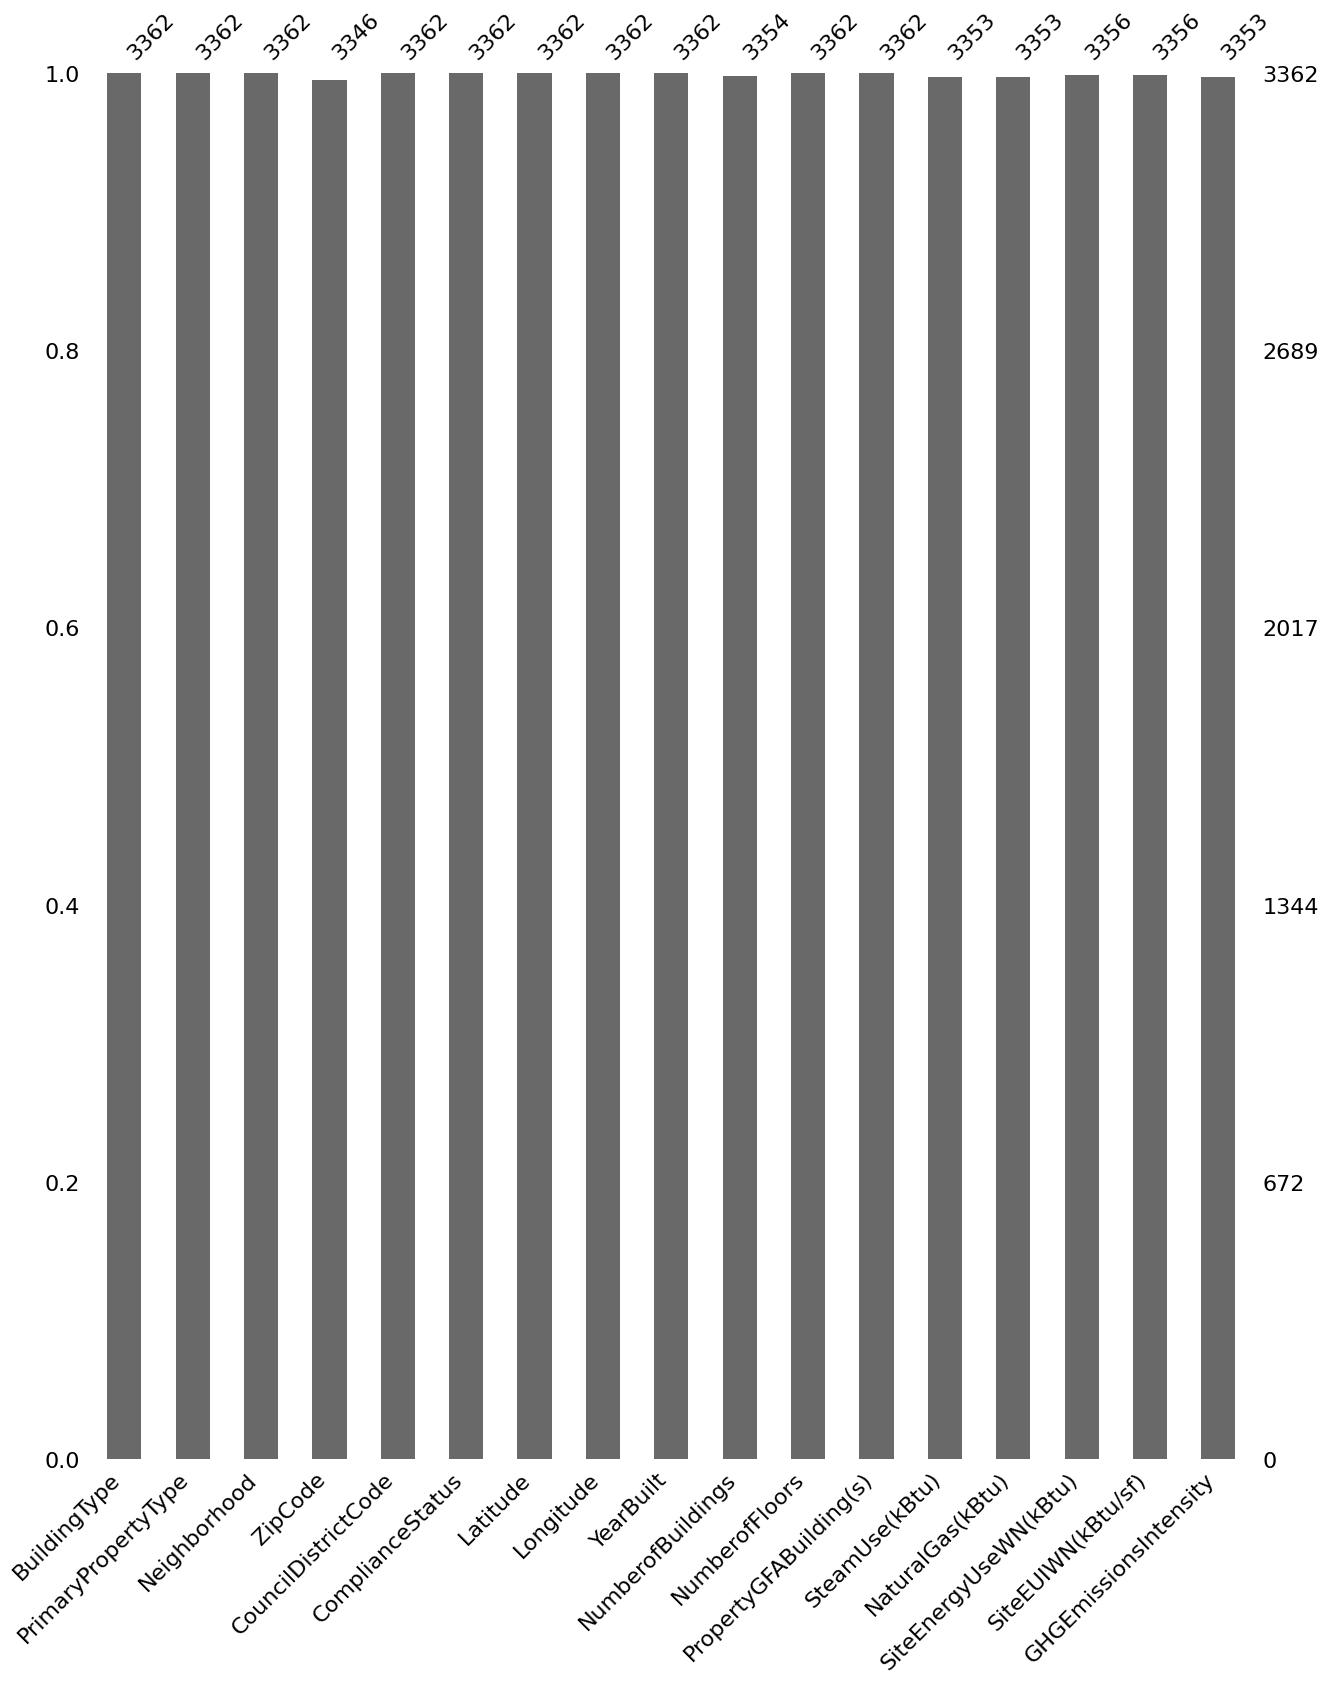

Removing 1607 non-residential buildings
Showing now missing values plot:



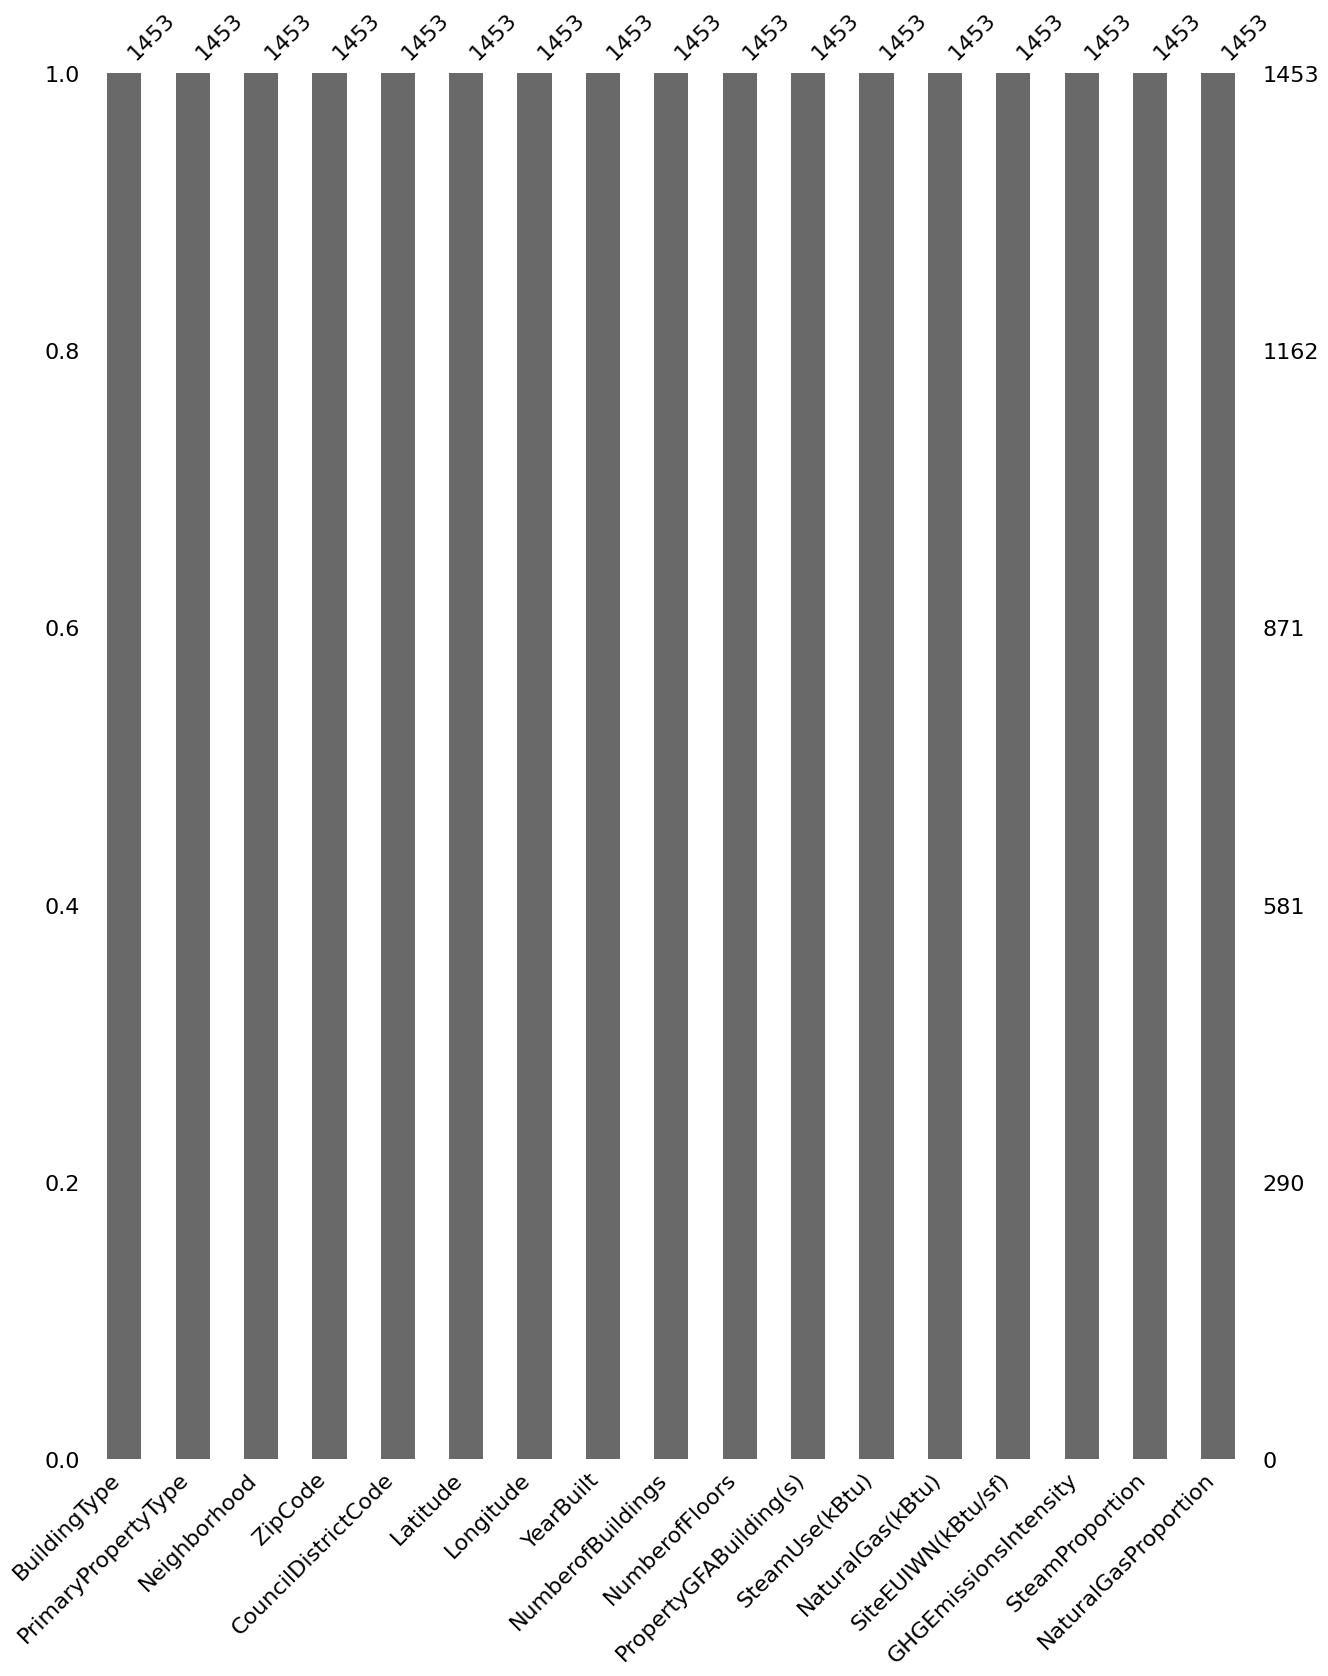

Dataset size after cleaning and preparation:1453

Starting univariate analysis.



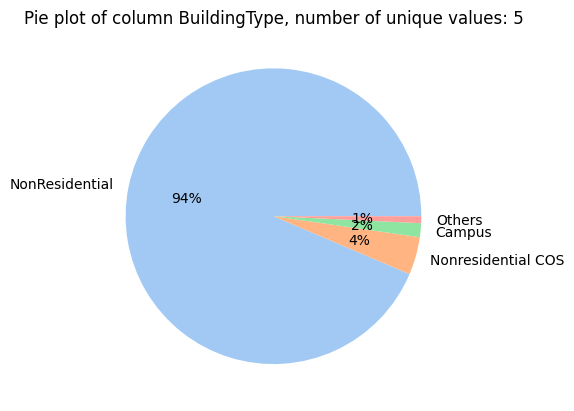

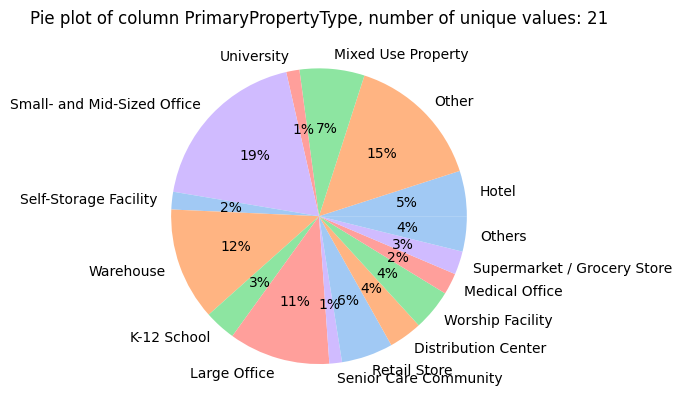

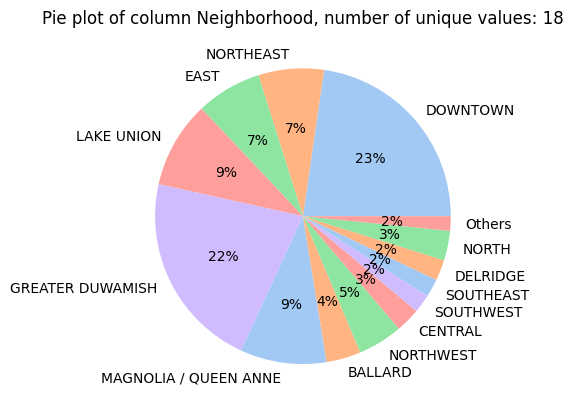

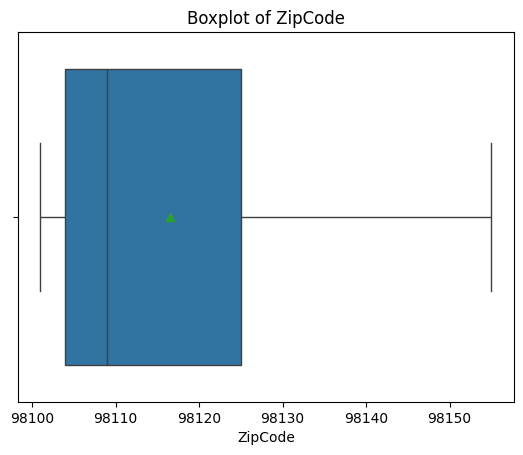

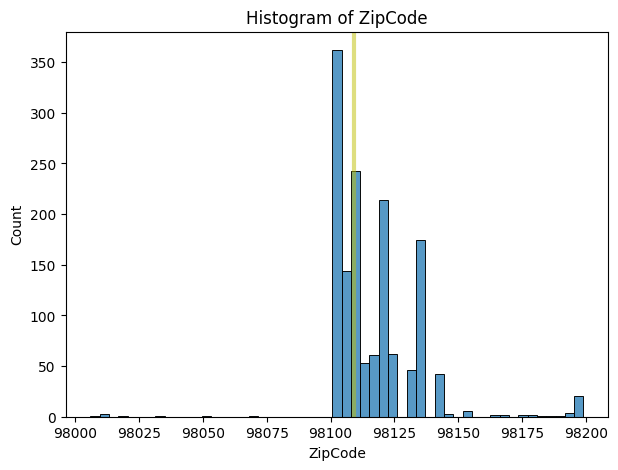

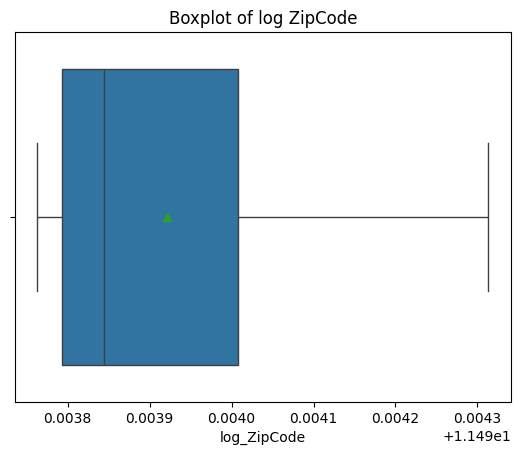

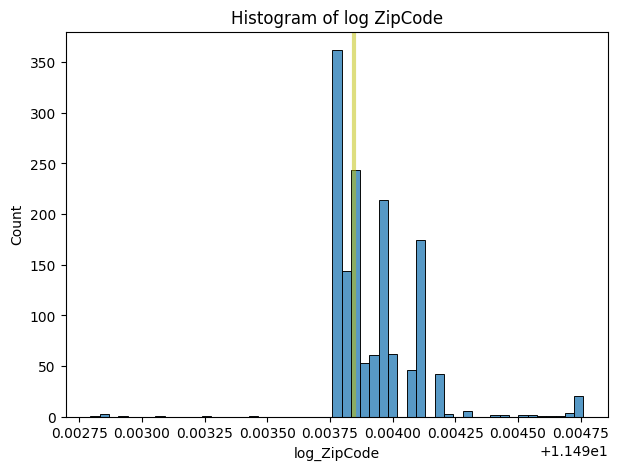

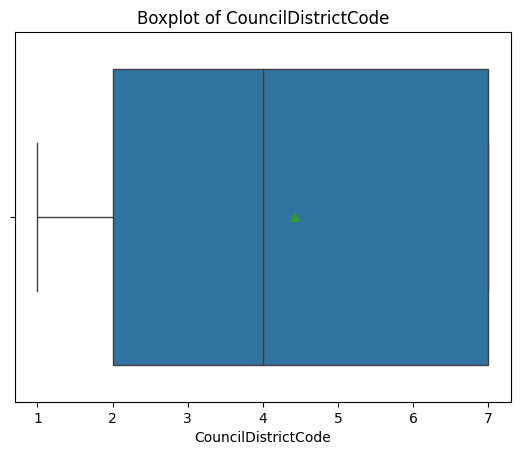

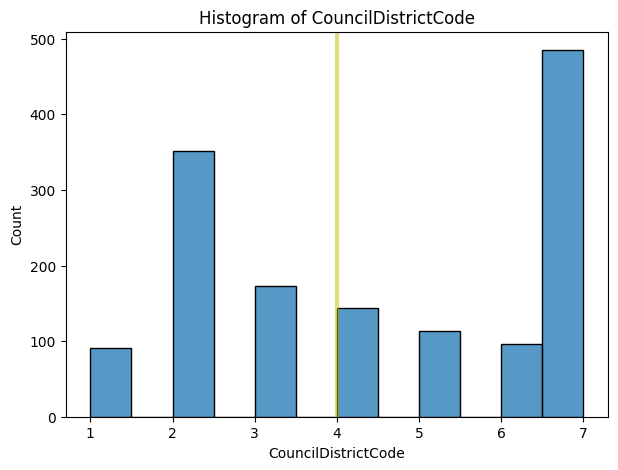

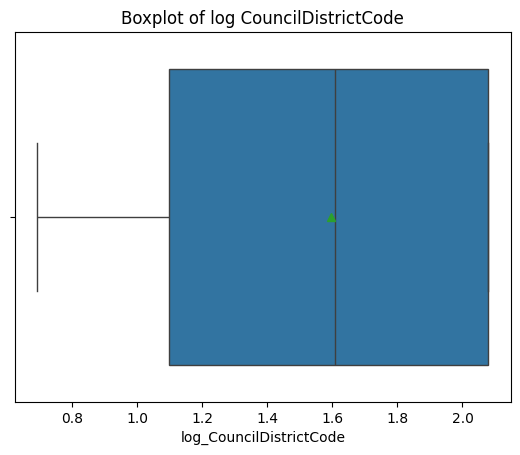

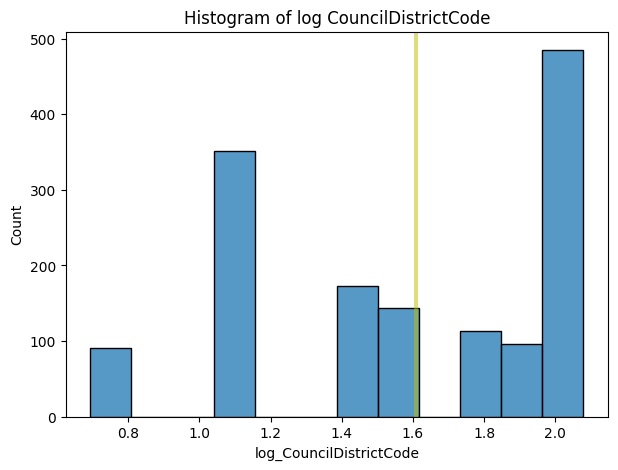

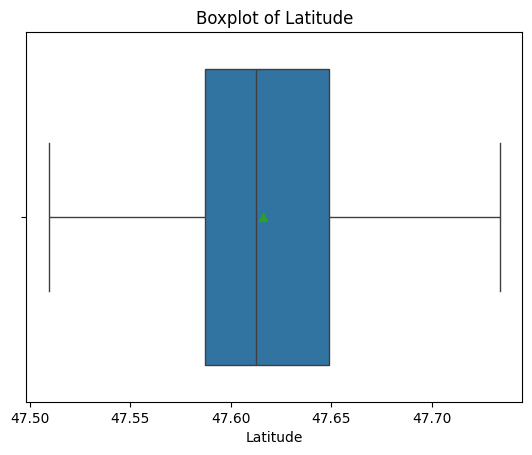

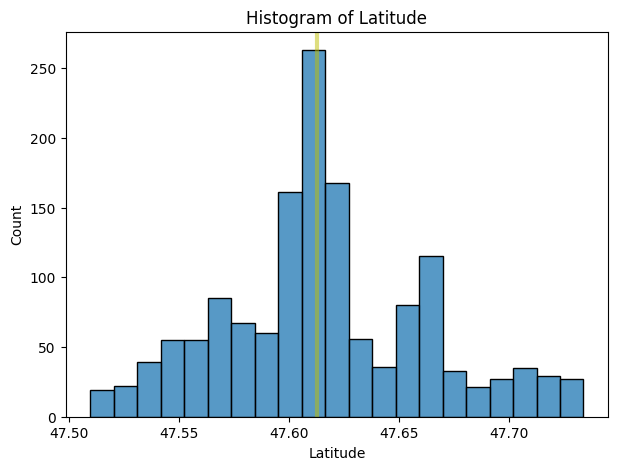

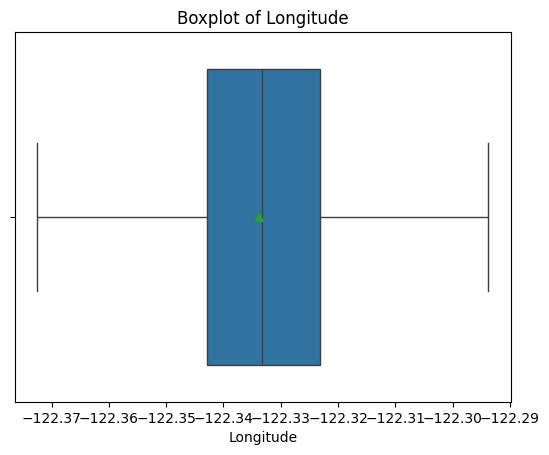

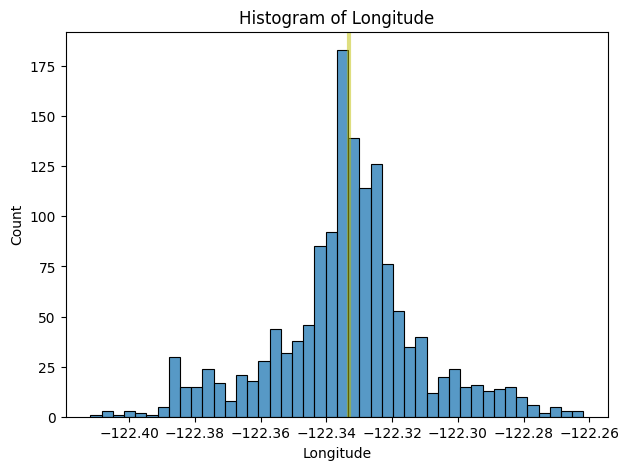

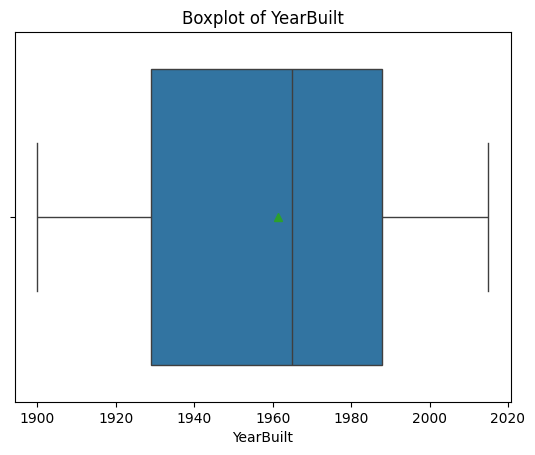

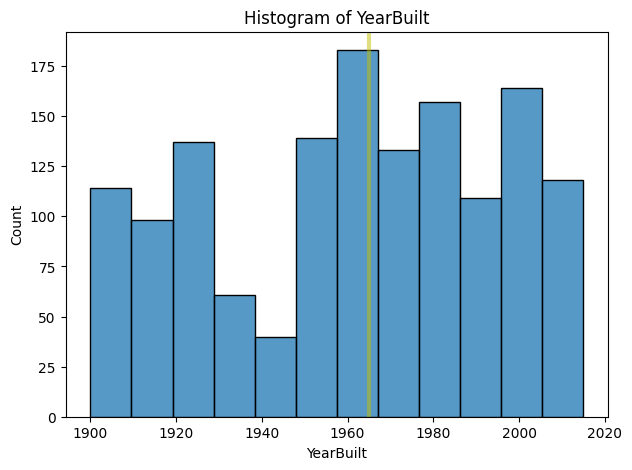

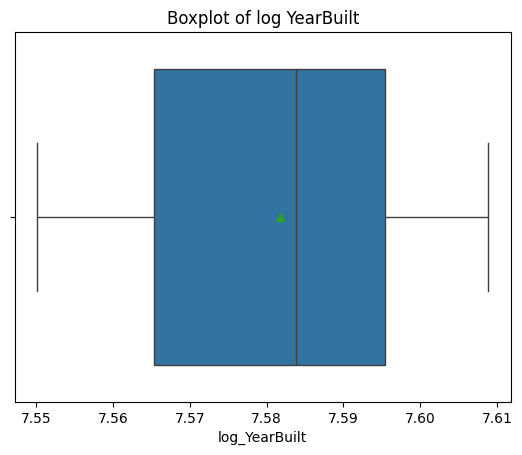

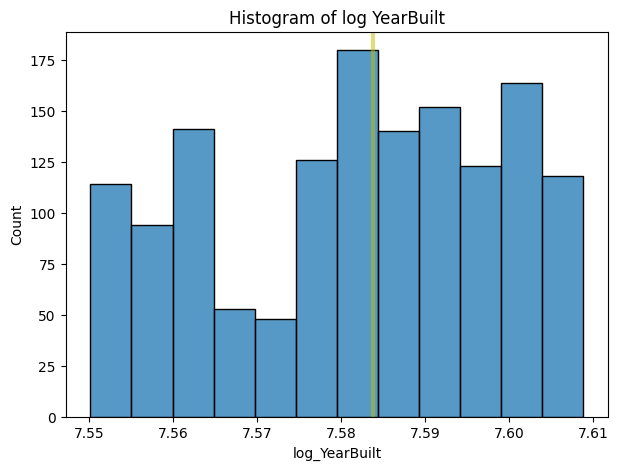

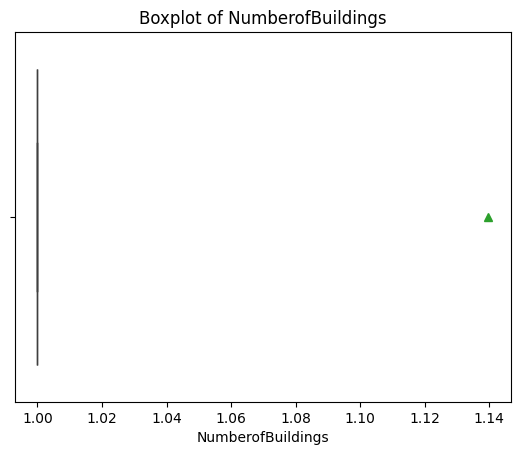

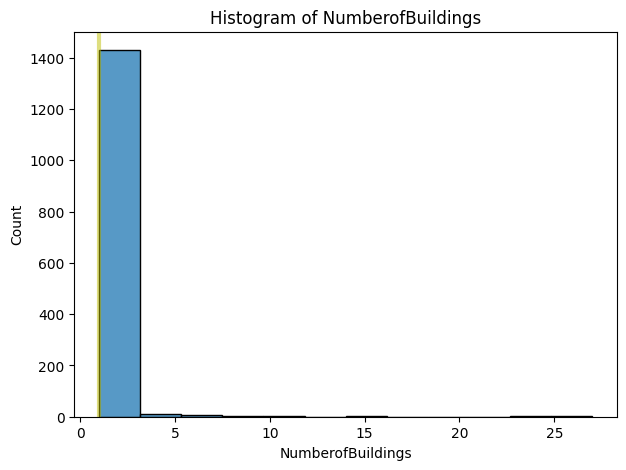

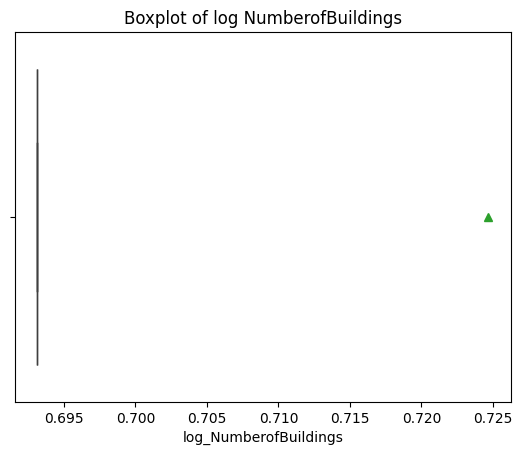

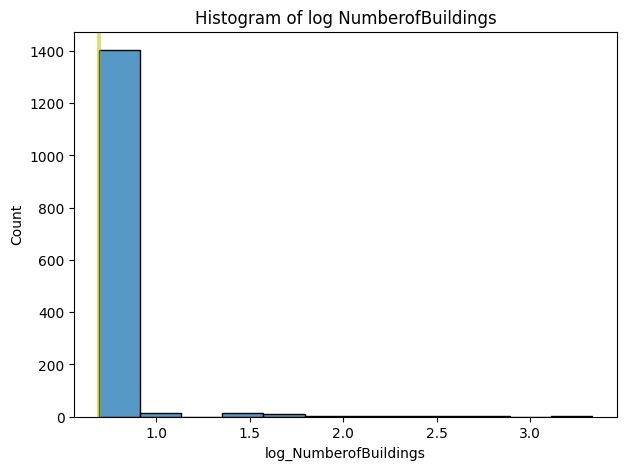

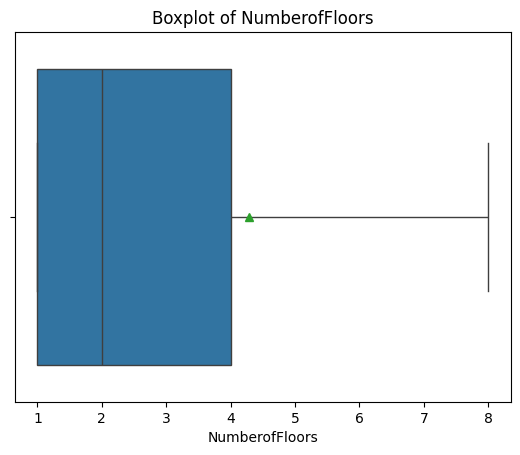

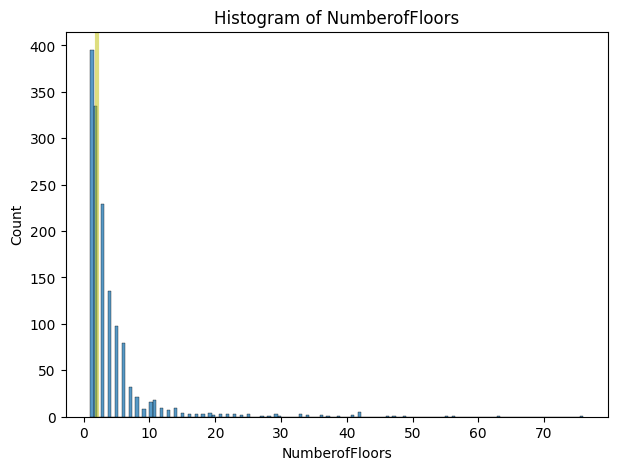

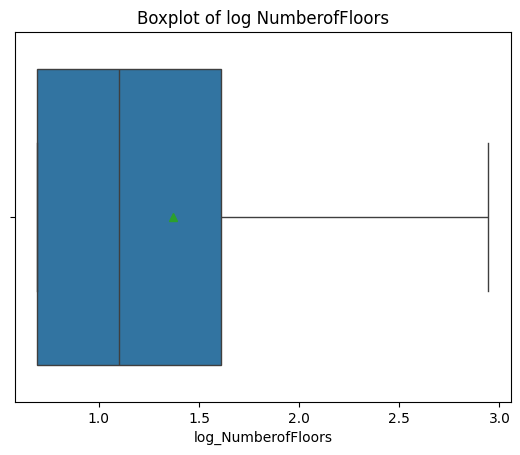

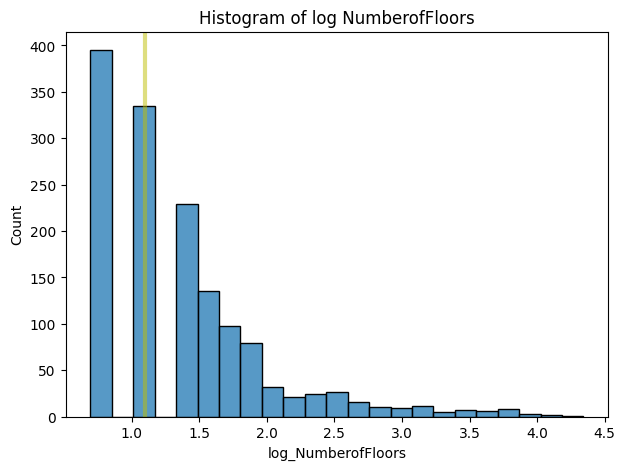

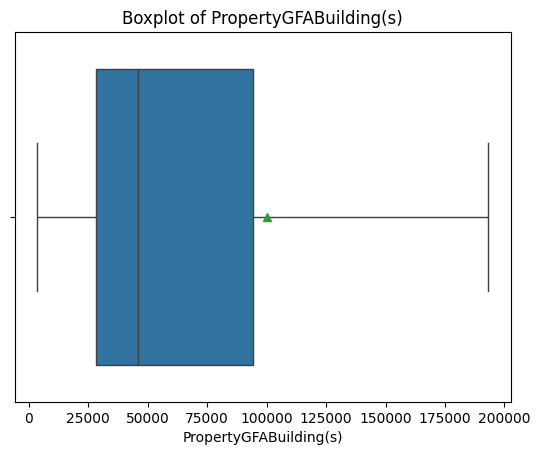

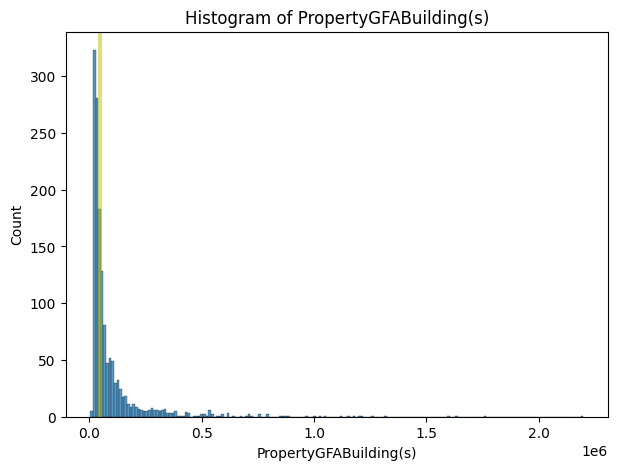

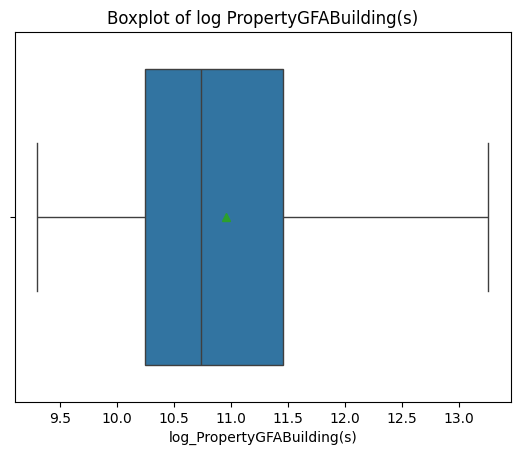

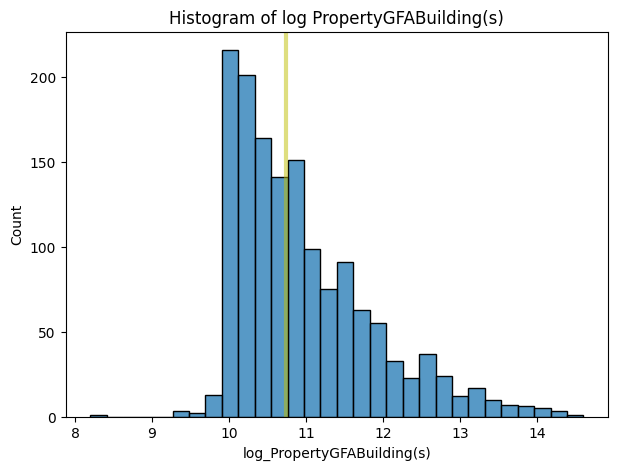

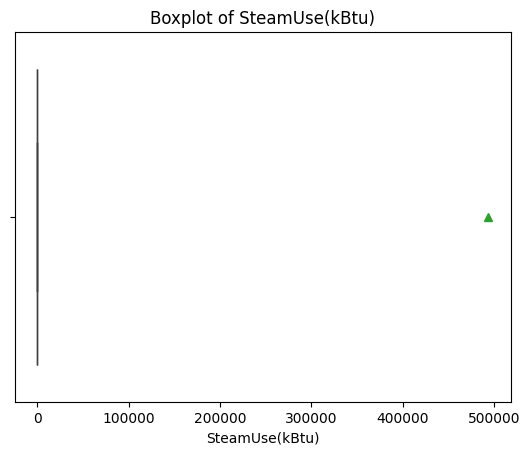

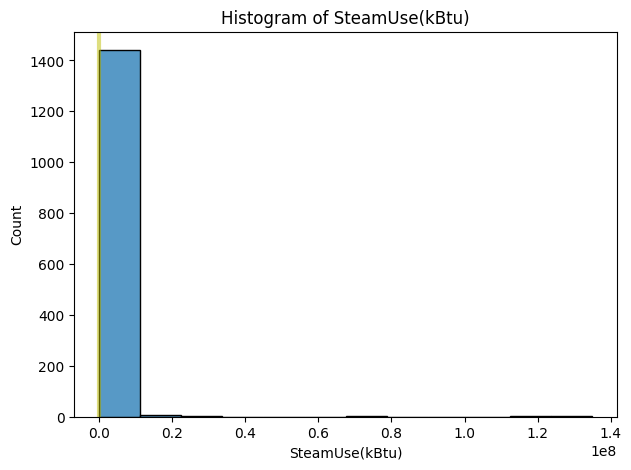

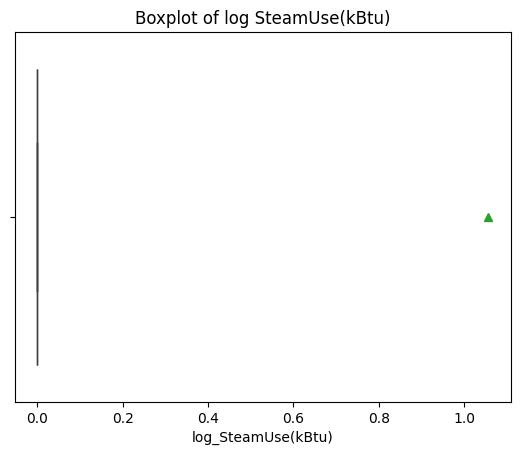

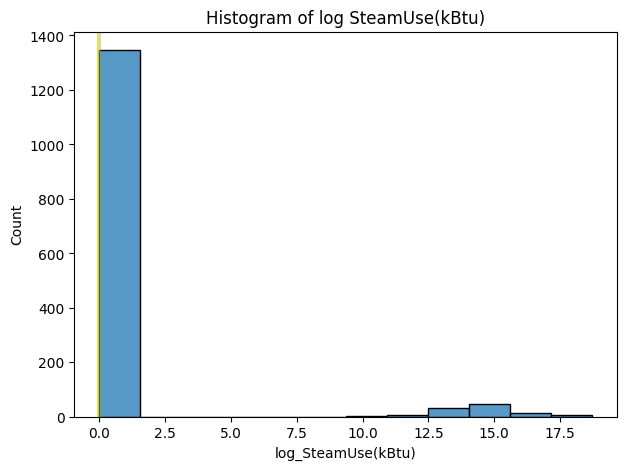

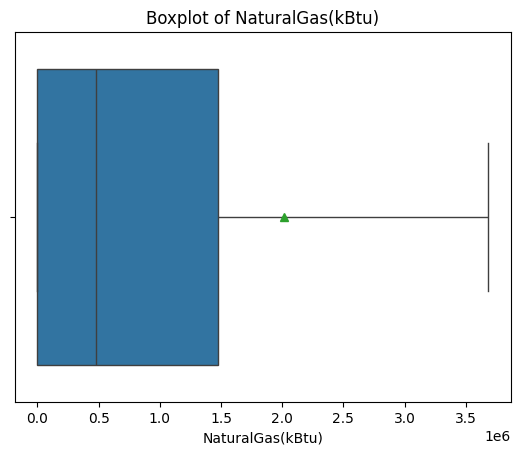

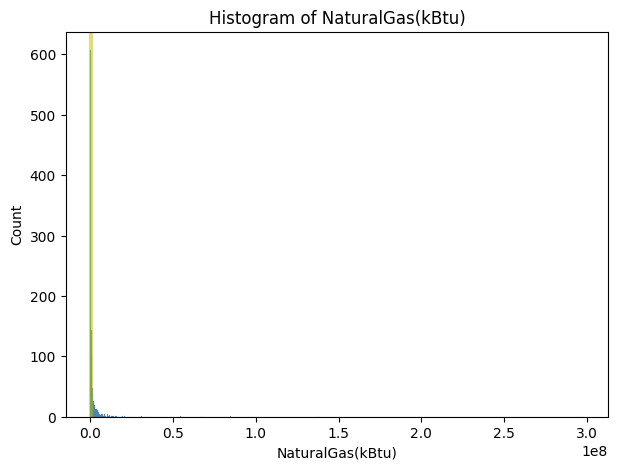

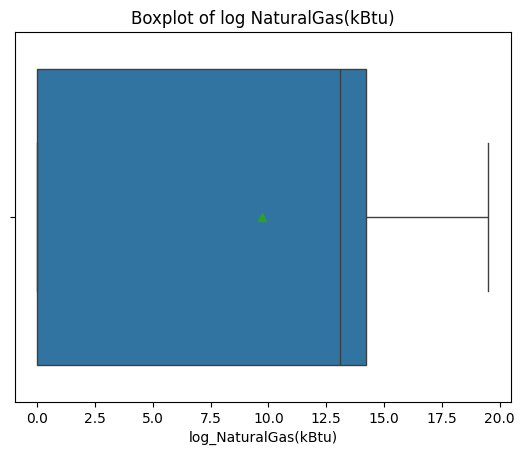

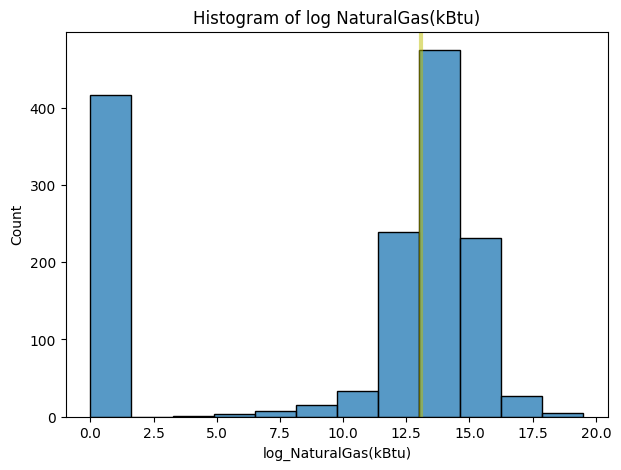

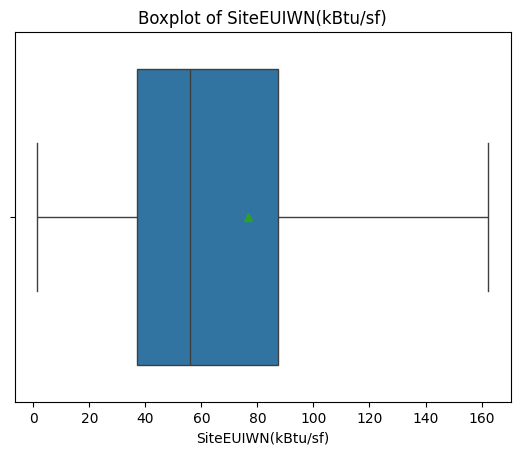

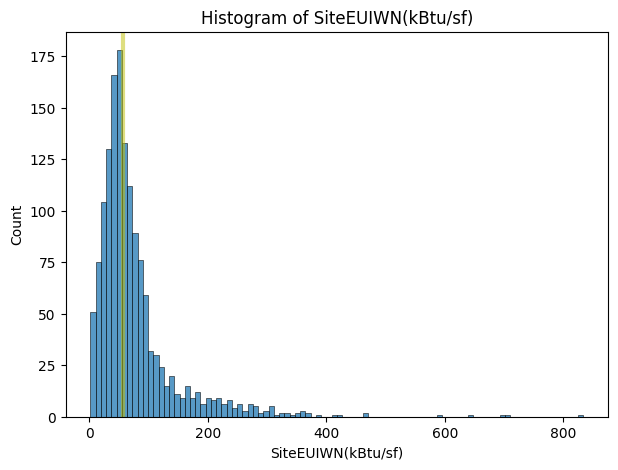

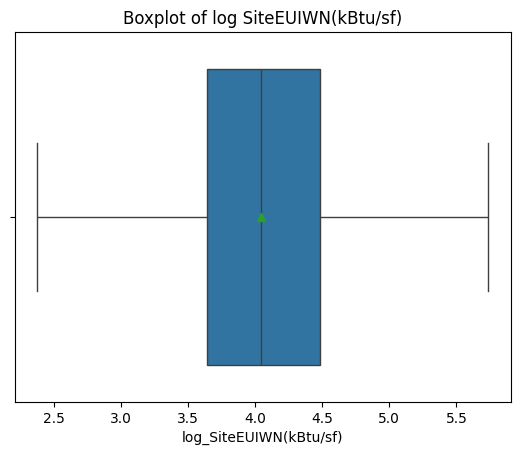

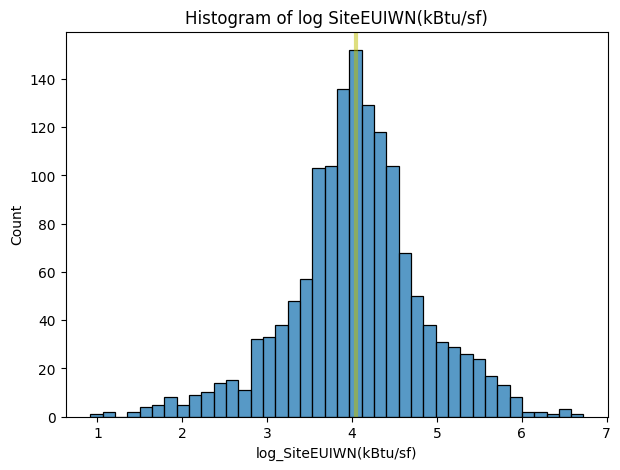

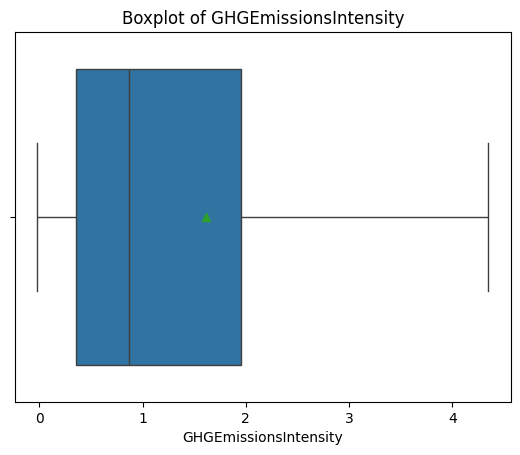

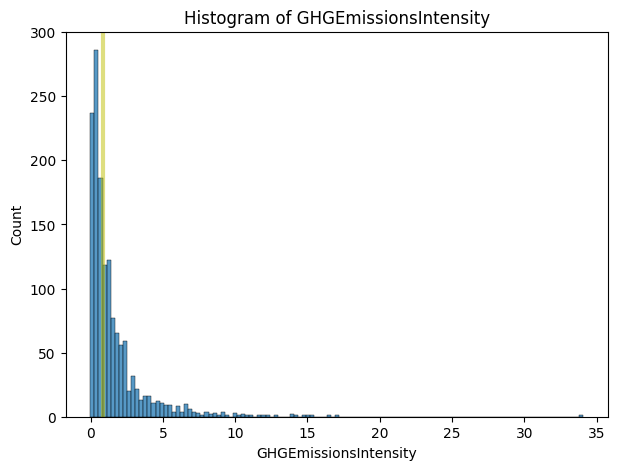

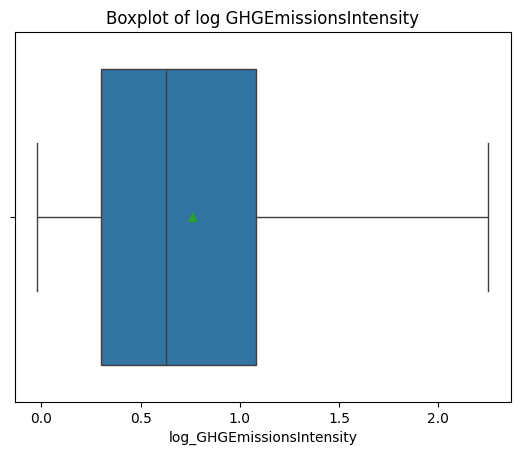

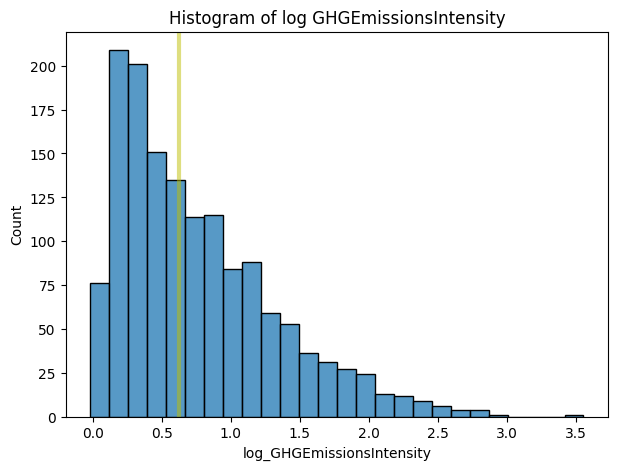

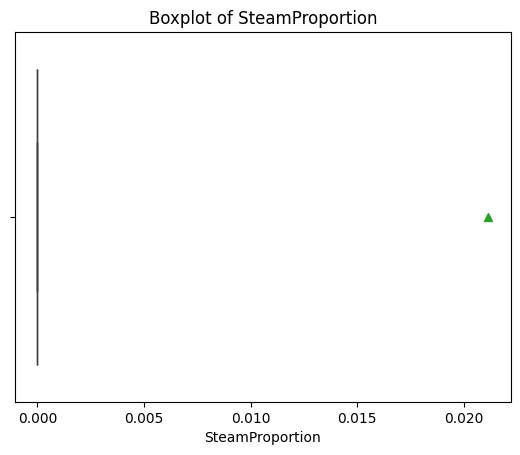

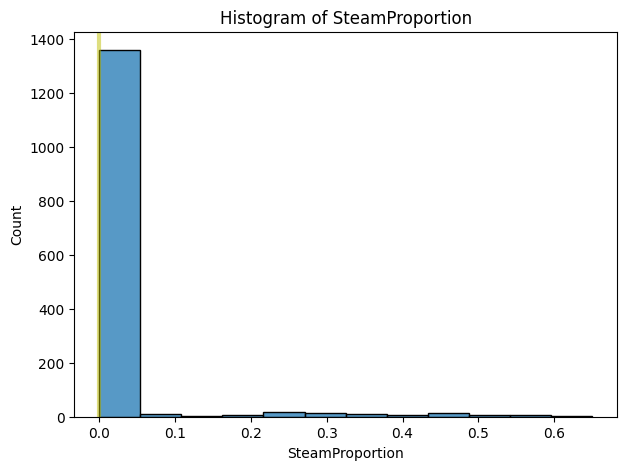

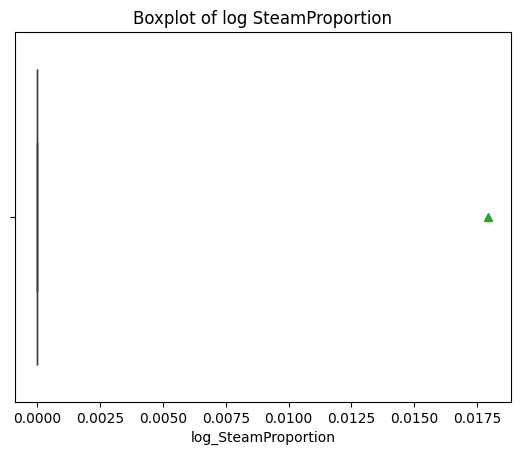

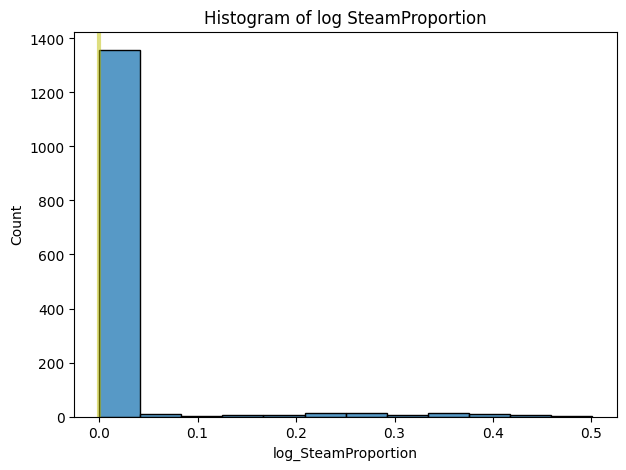

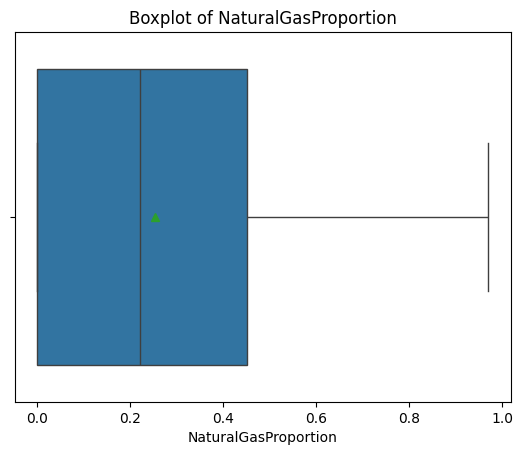

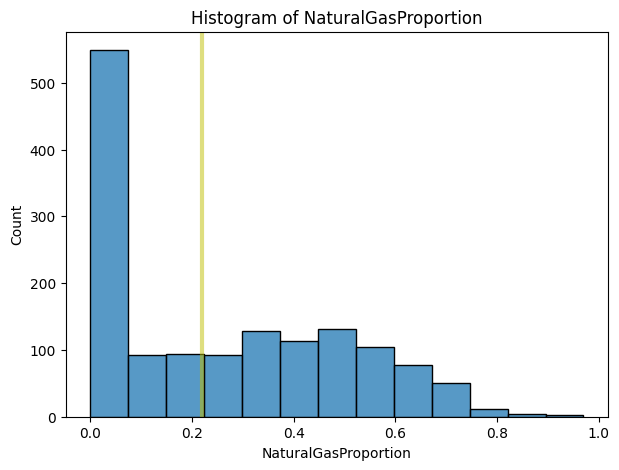

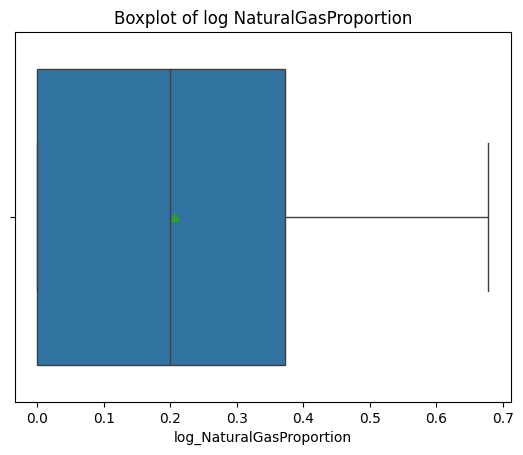

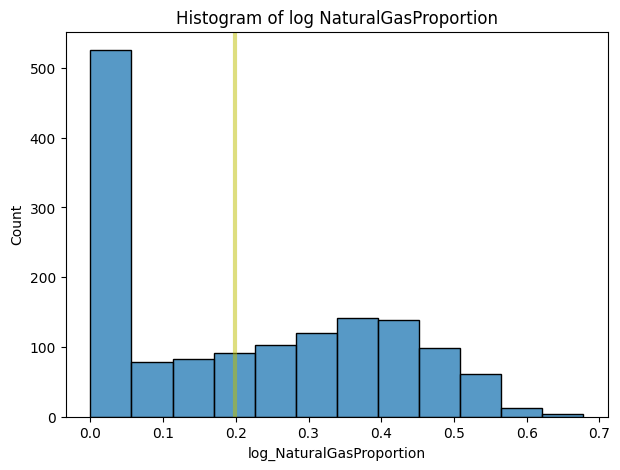

Starting ACP analysis.



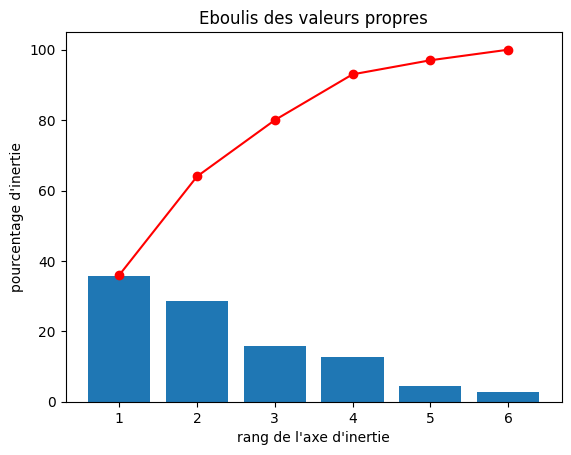

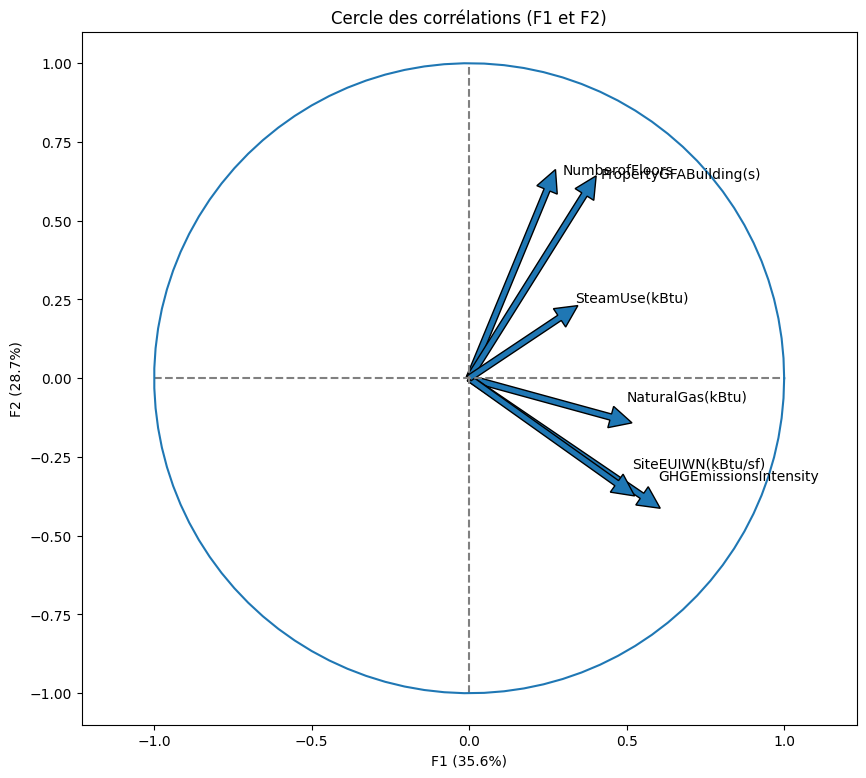

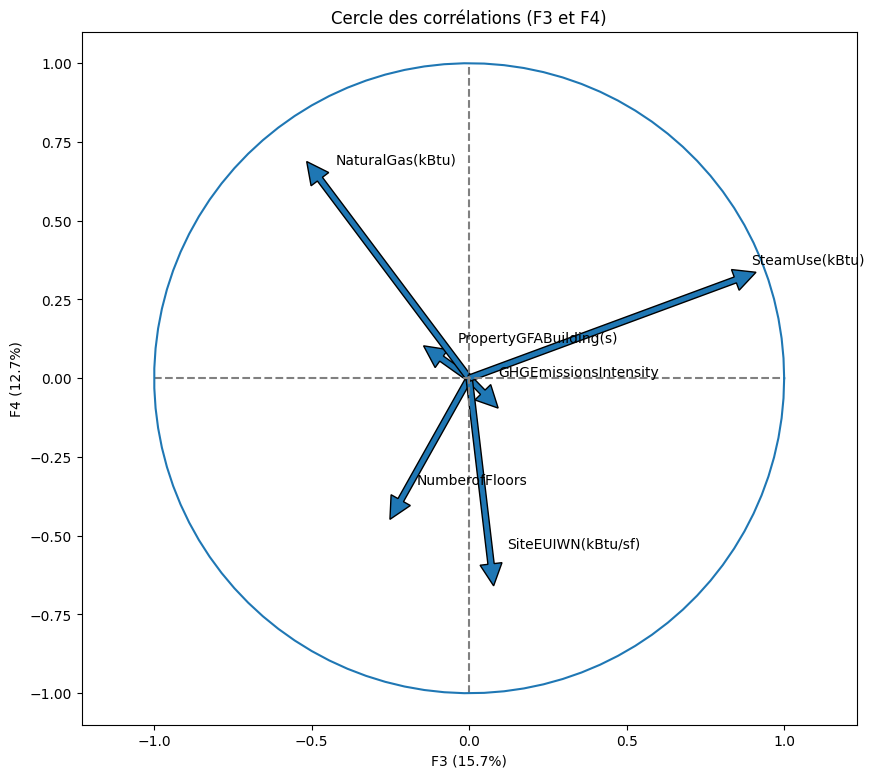

Starting bivariate analysis for the target column:SiteEUIWN(kBtu/sf)



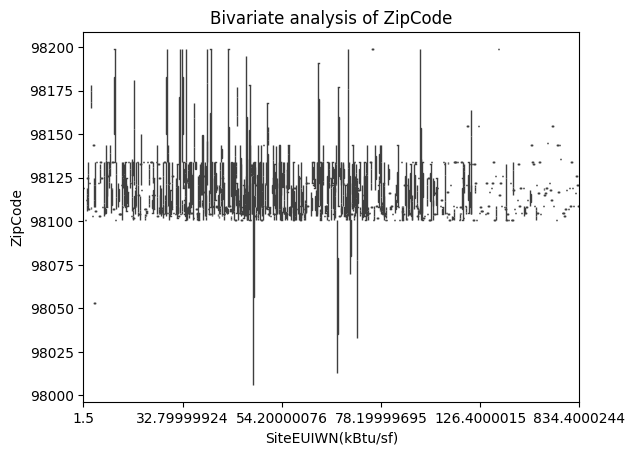

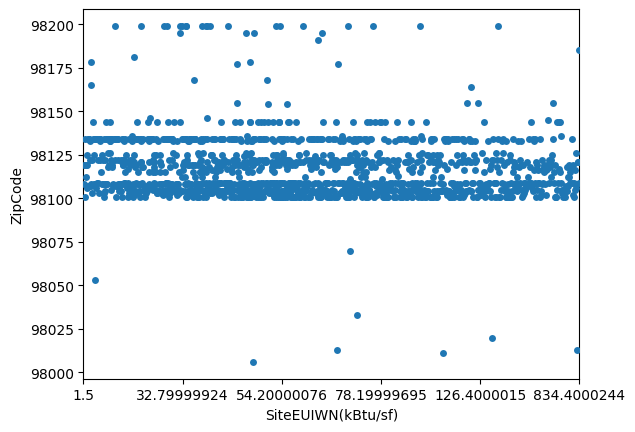

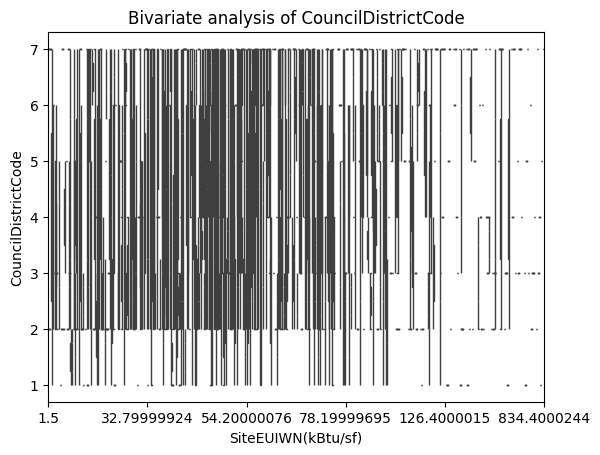

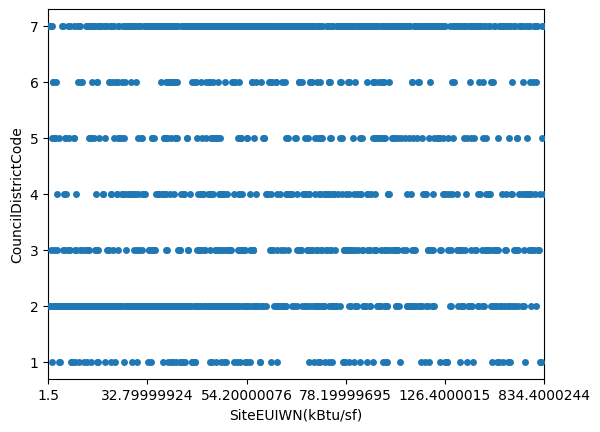

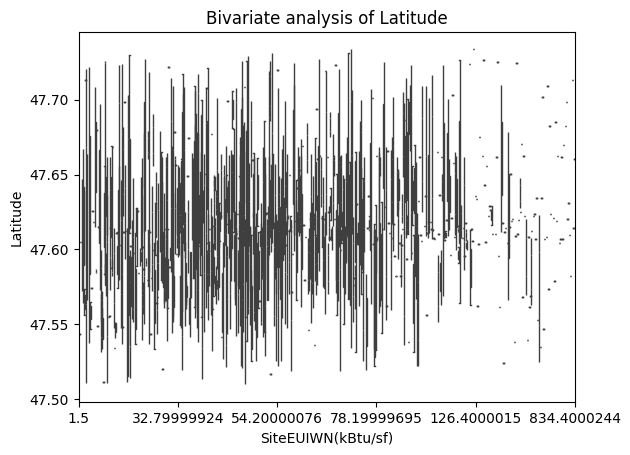

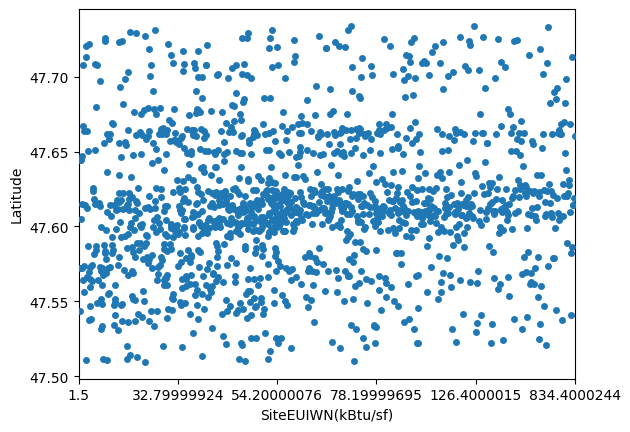

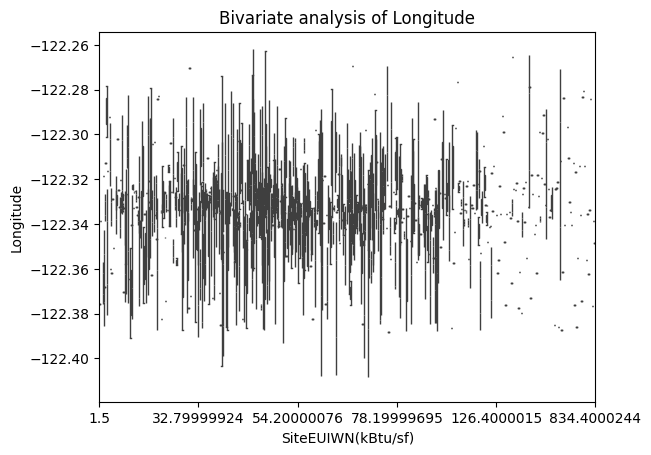

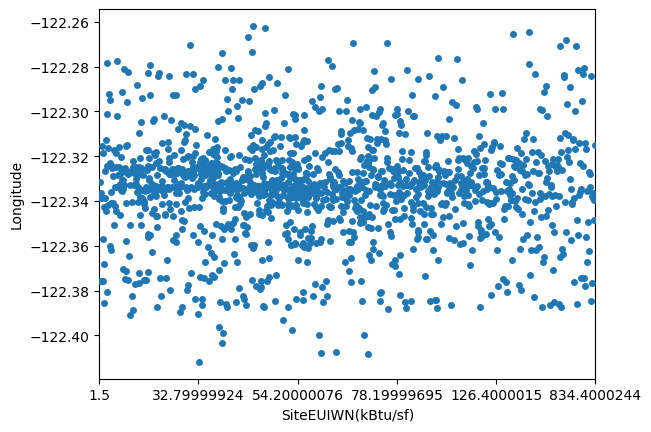

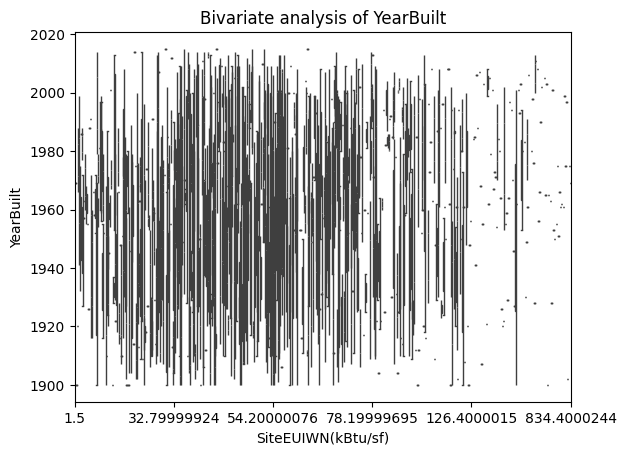

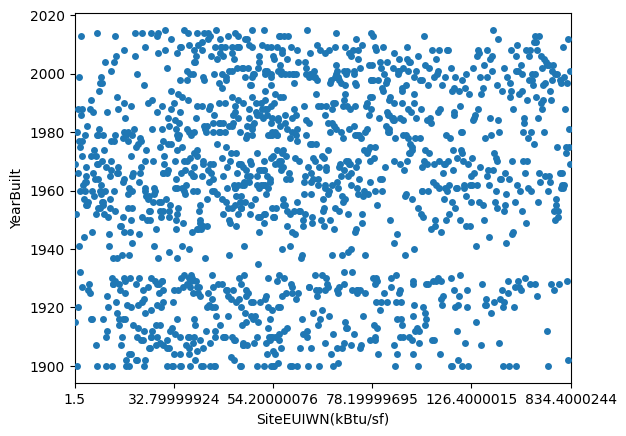

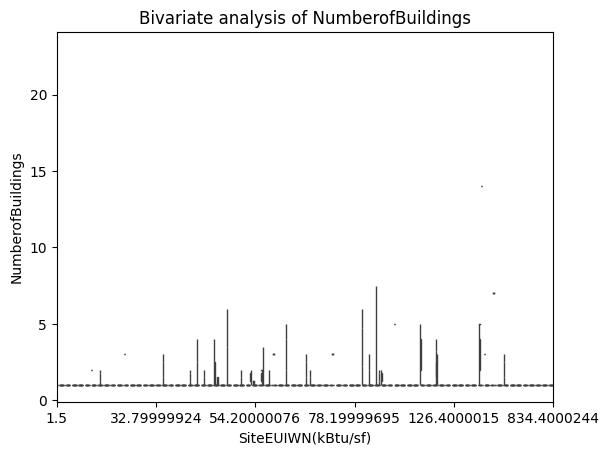

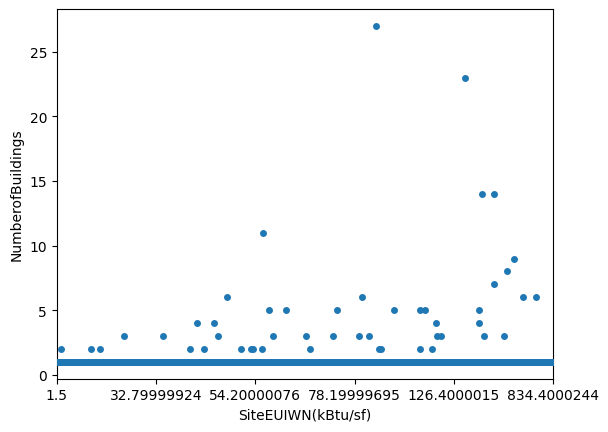

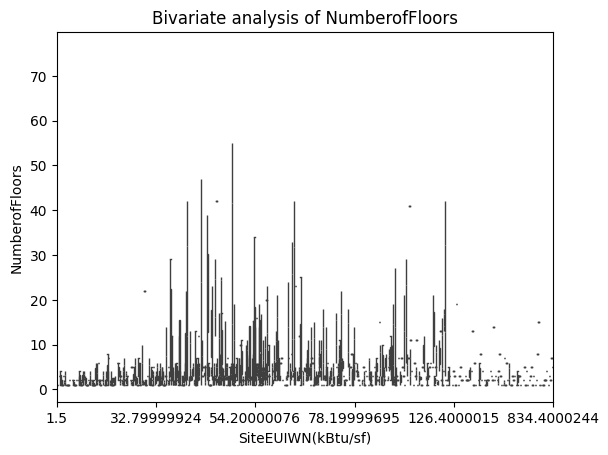

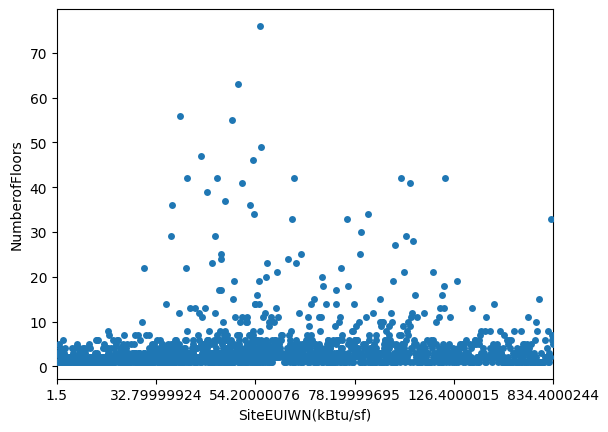

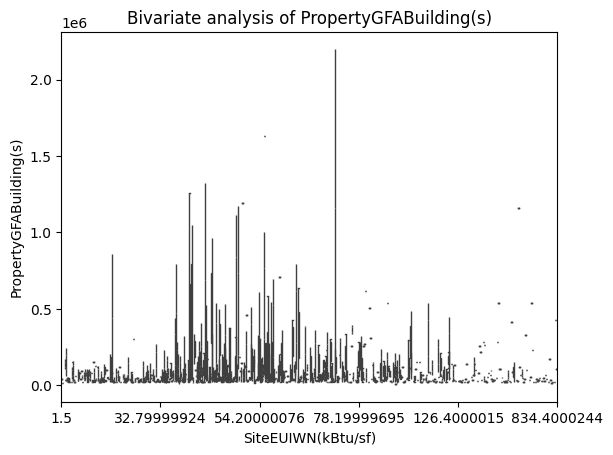

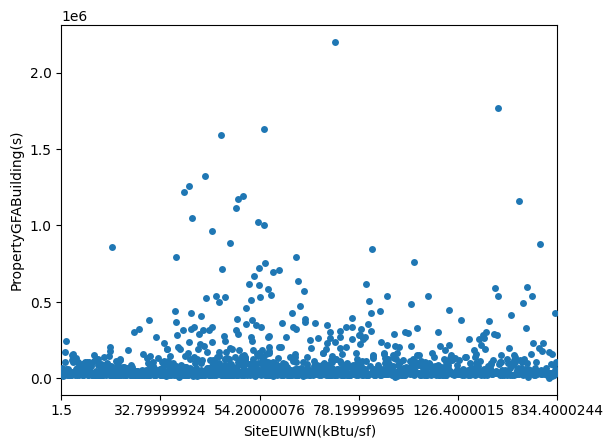

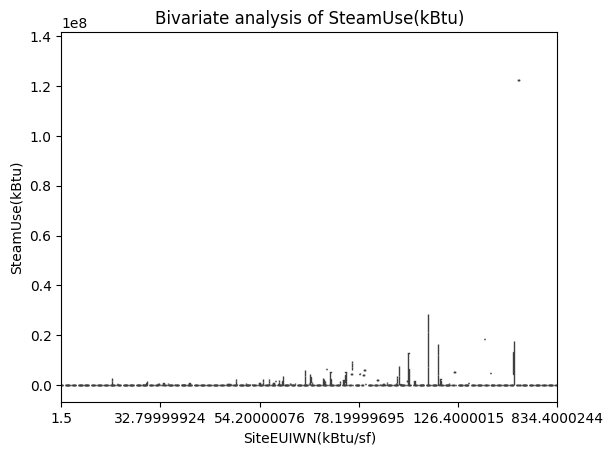

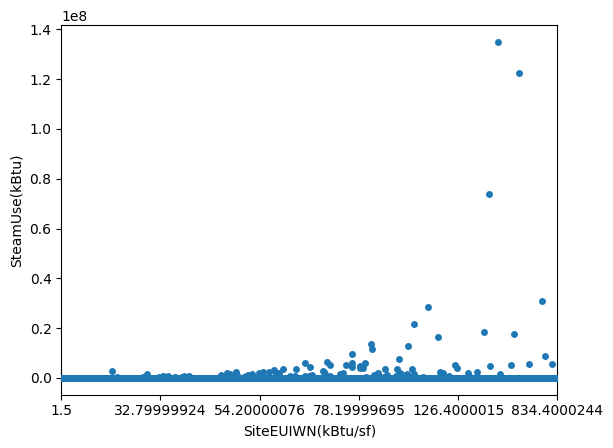

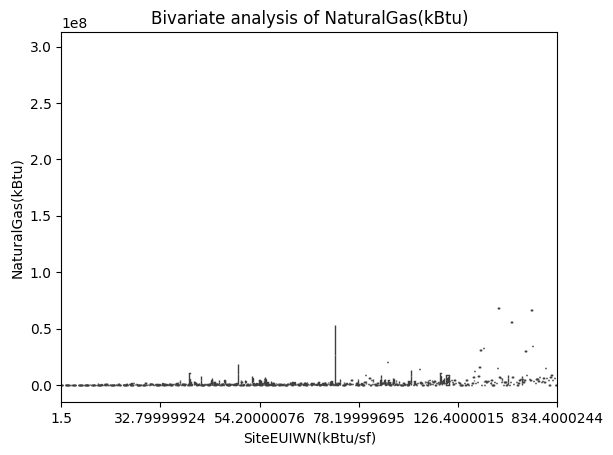

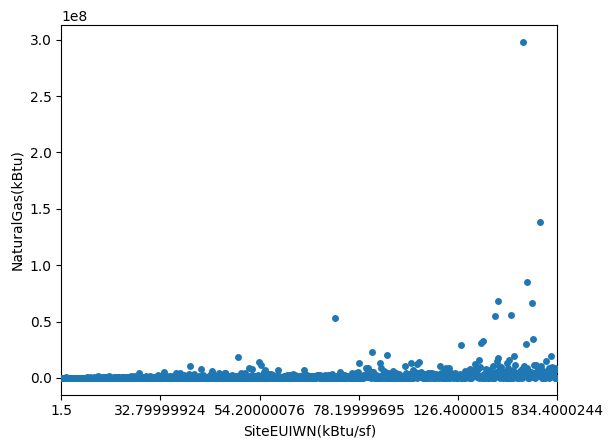

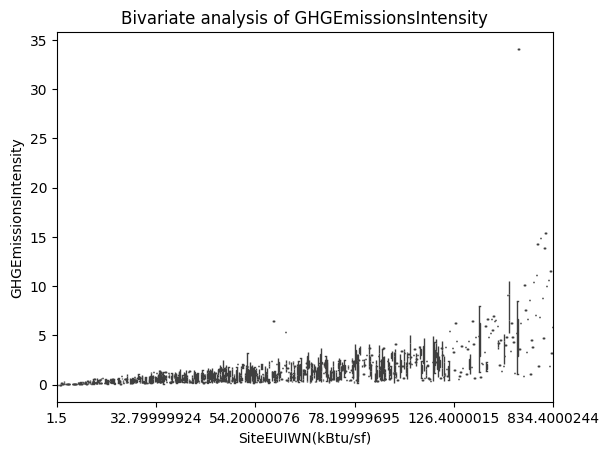

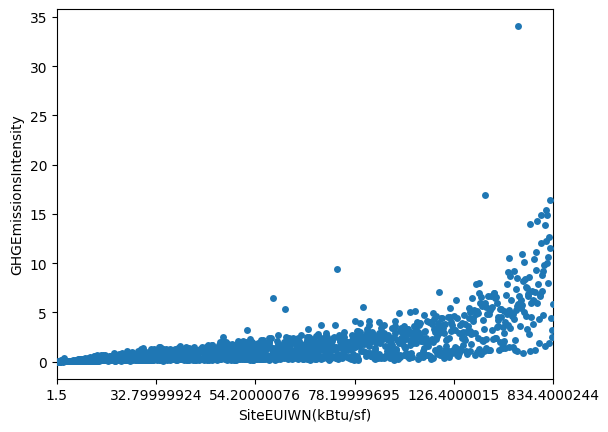

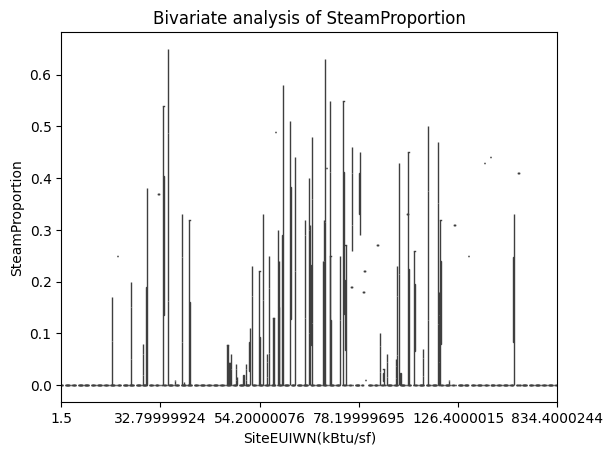

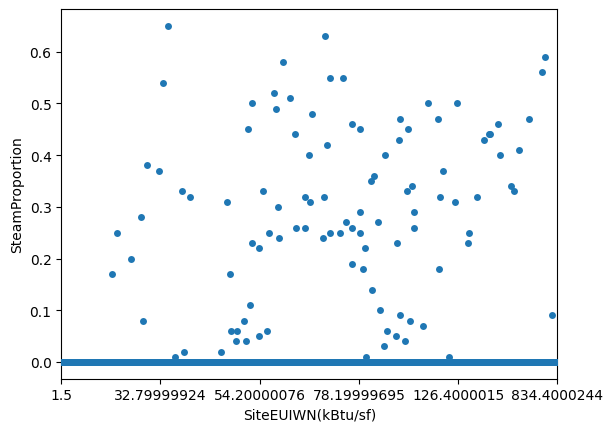

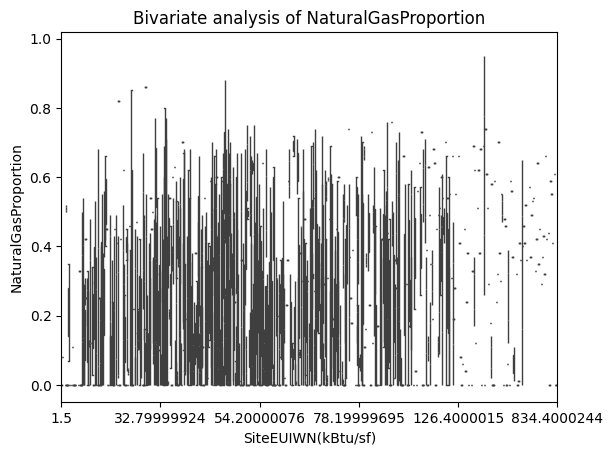

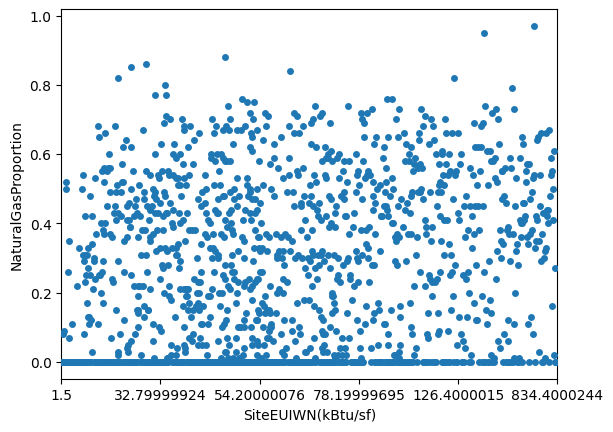

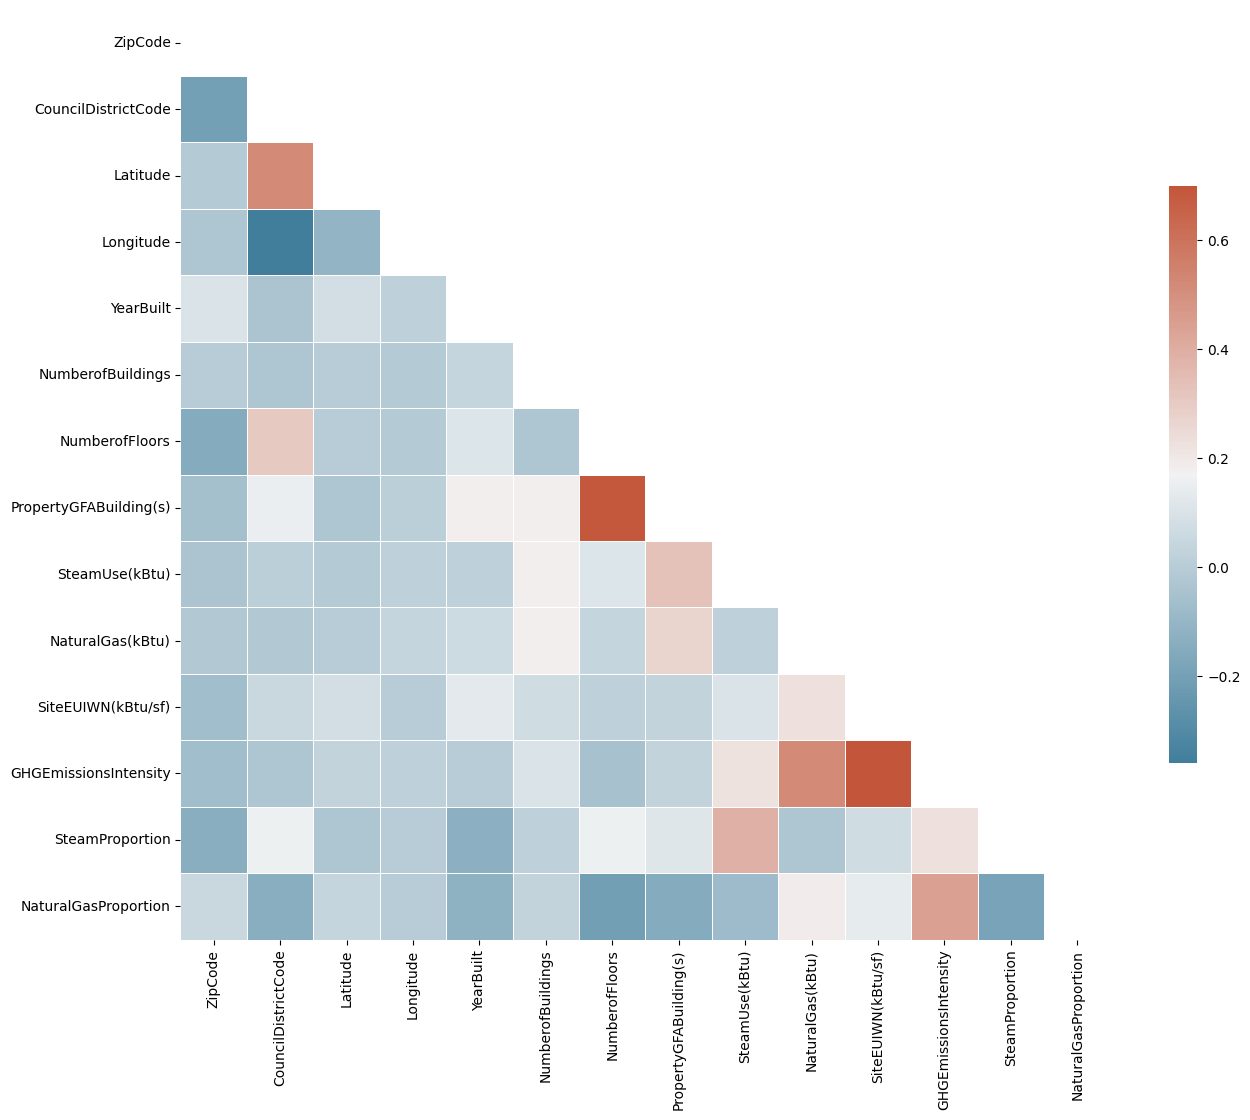

Starting bivariate analysis for the target column:GHGEmissionsIntensity



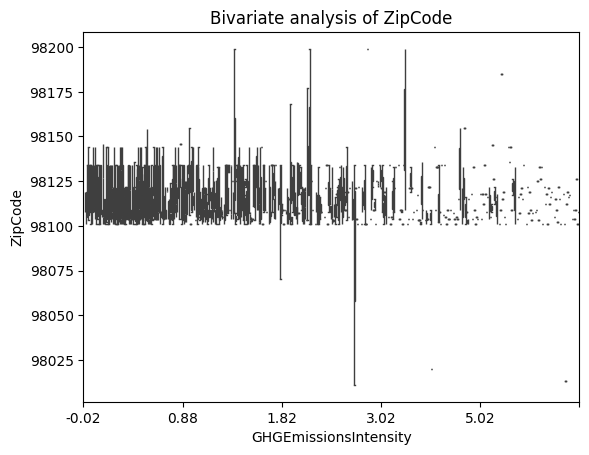

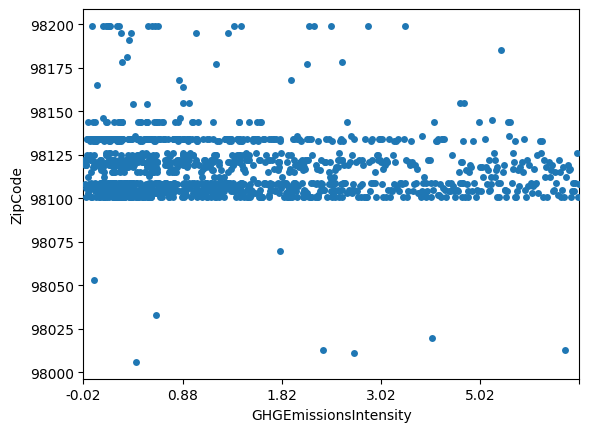

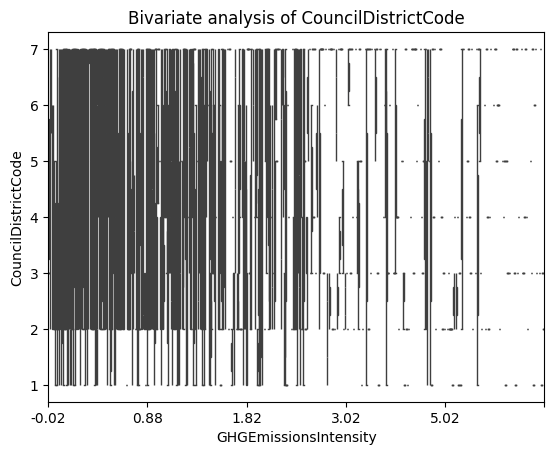

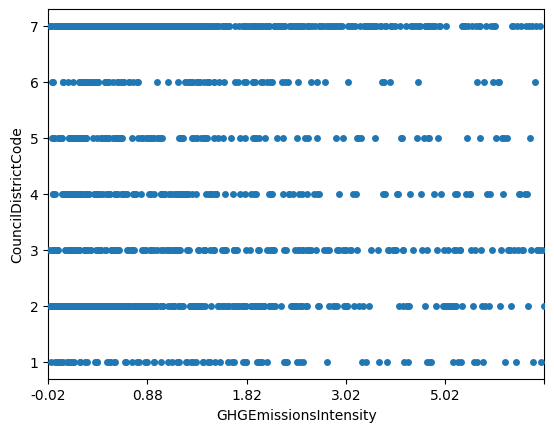

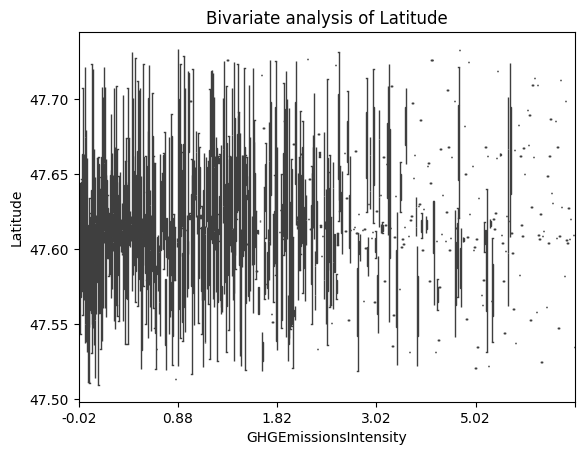

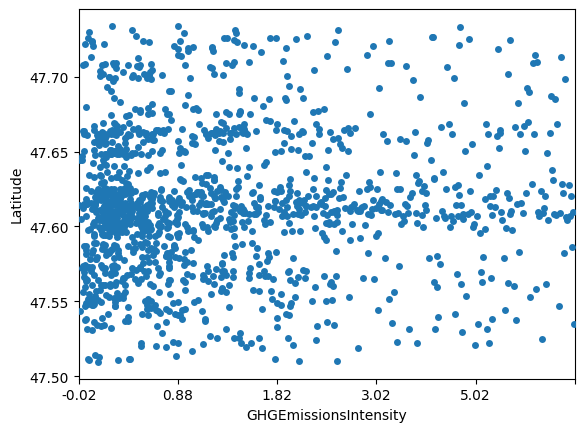

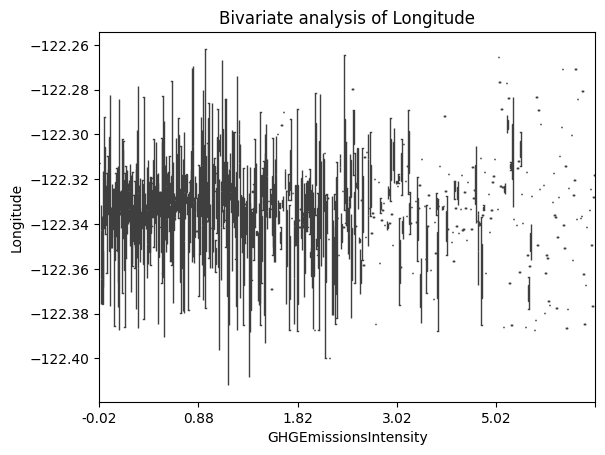

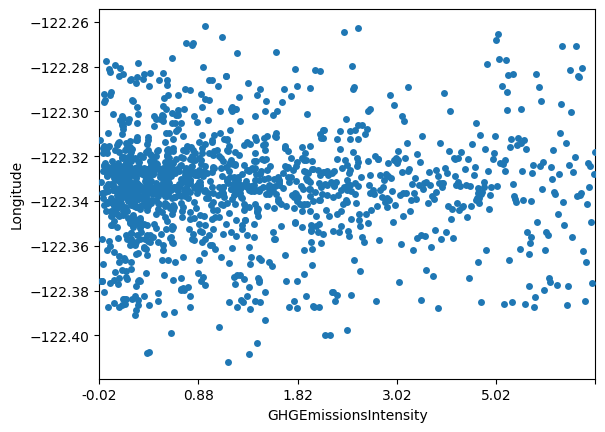

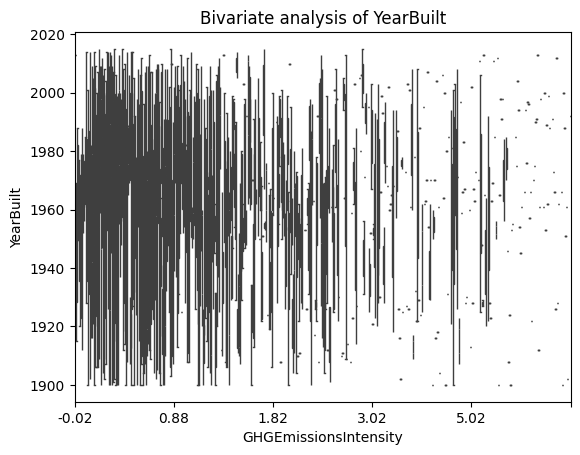

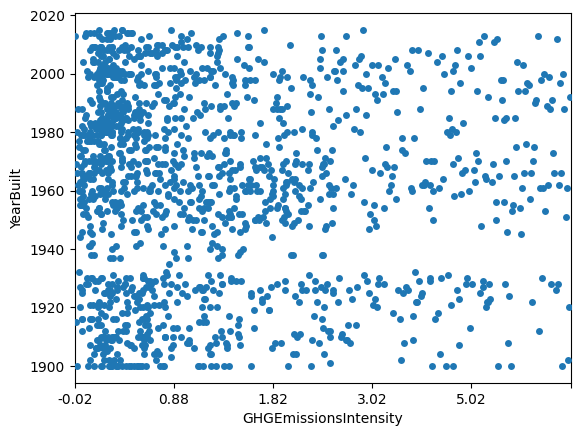

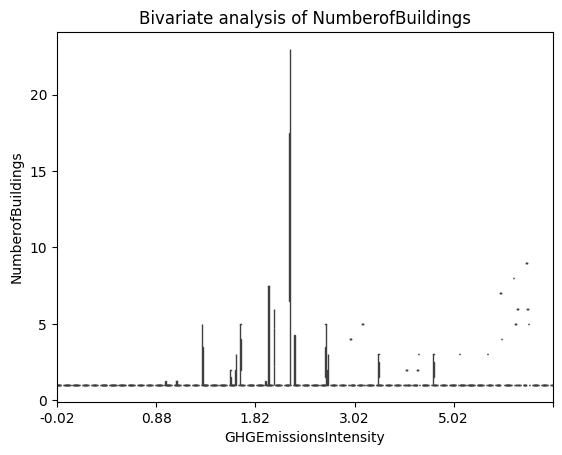

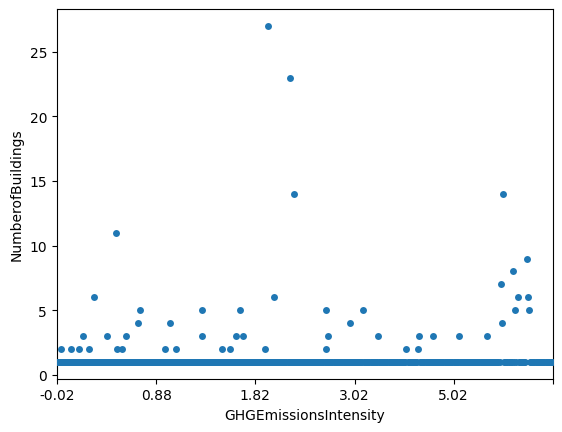

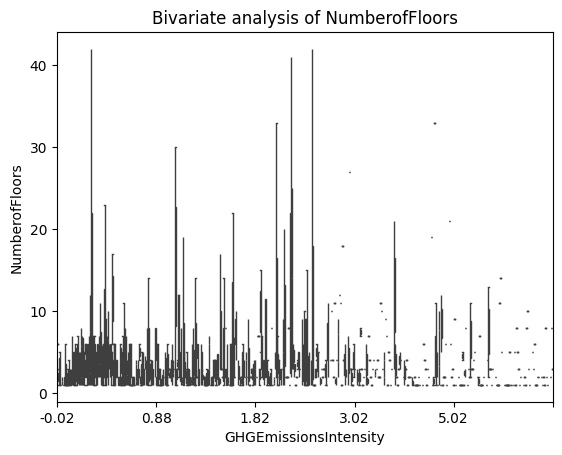

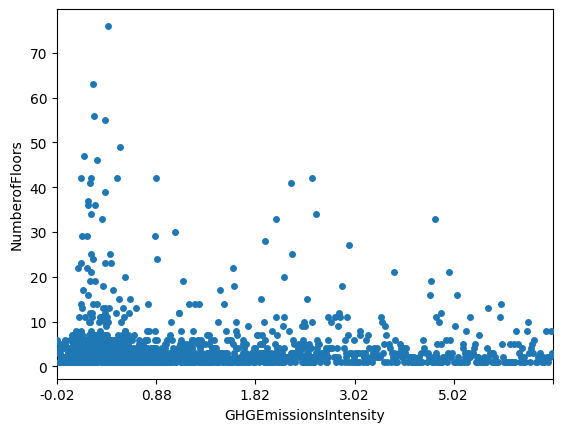

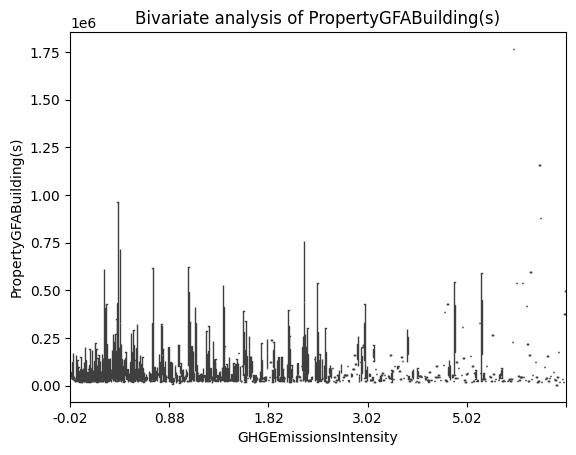

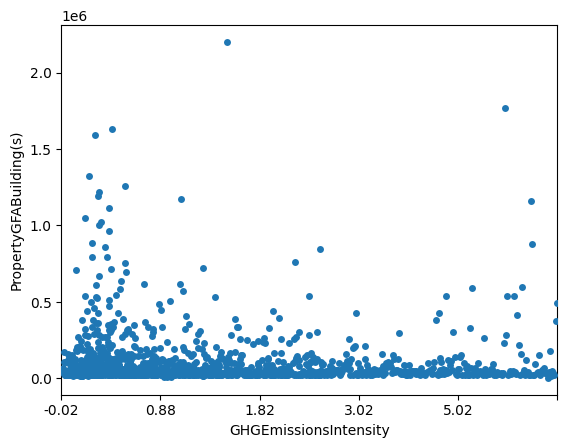

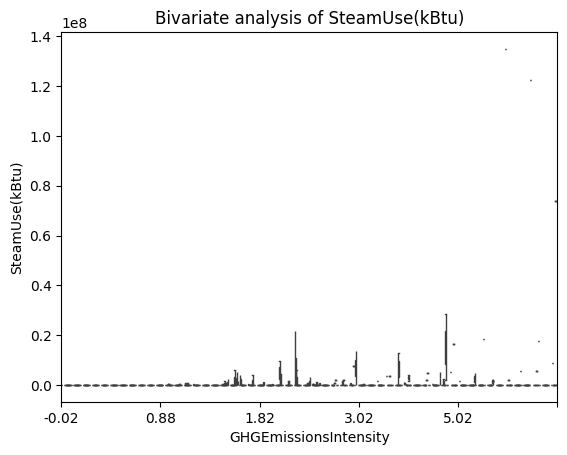

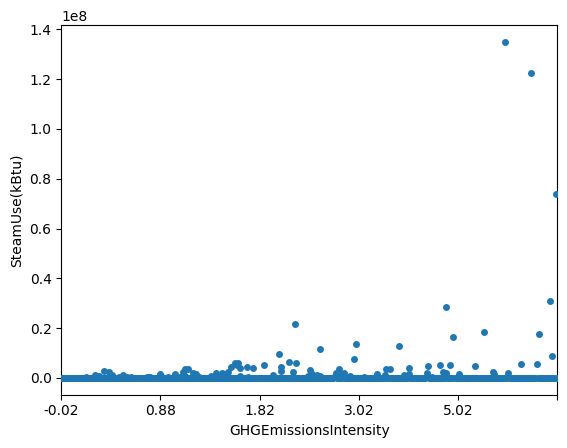

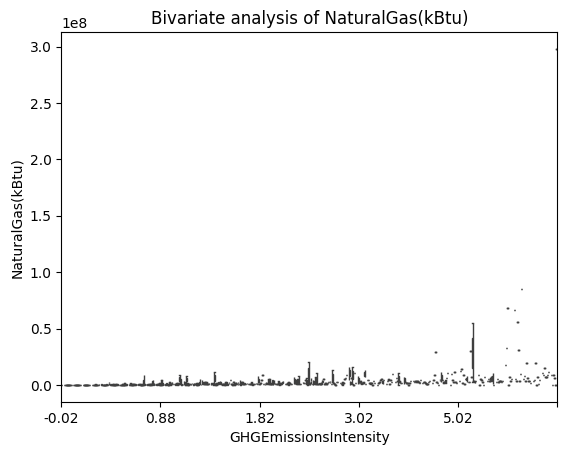

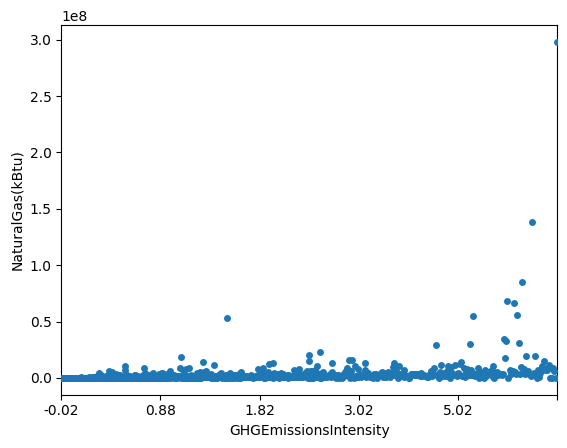

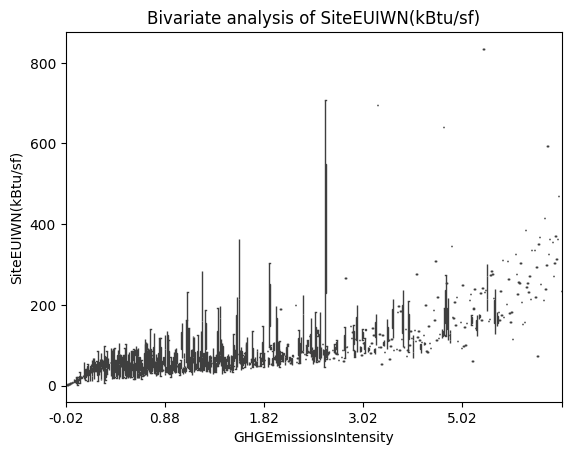

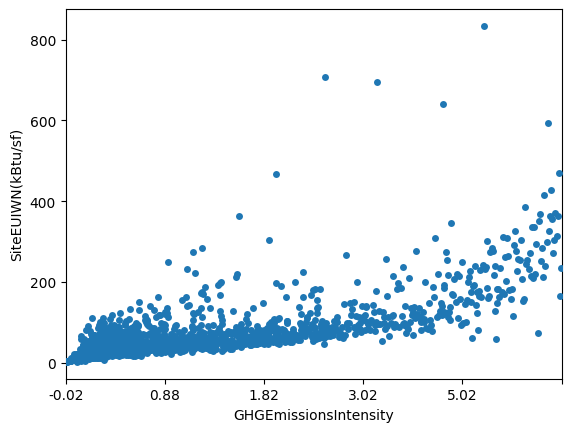

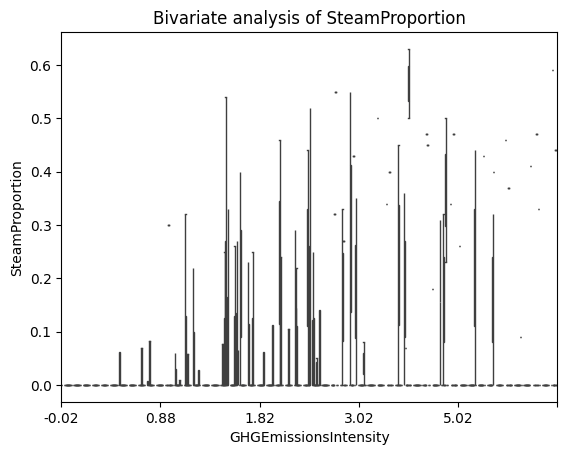

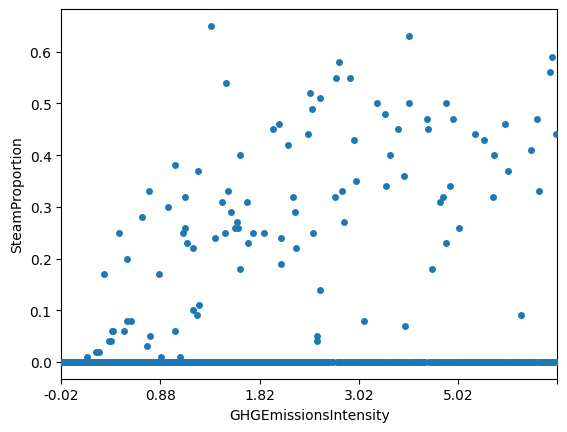

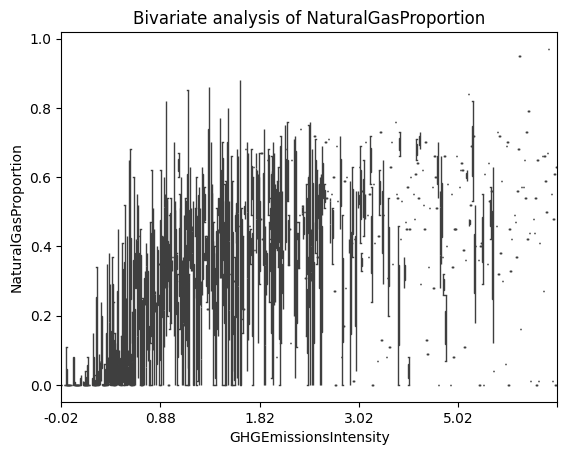

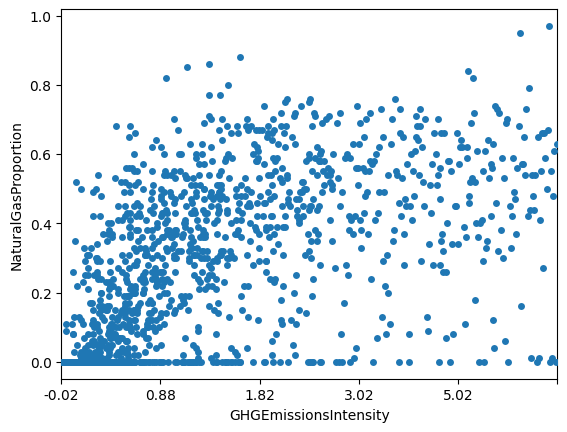

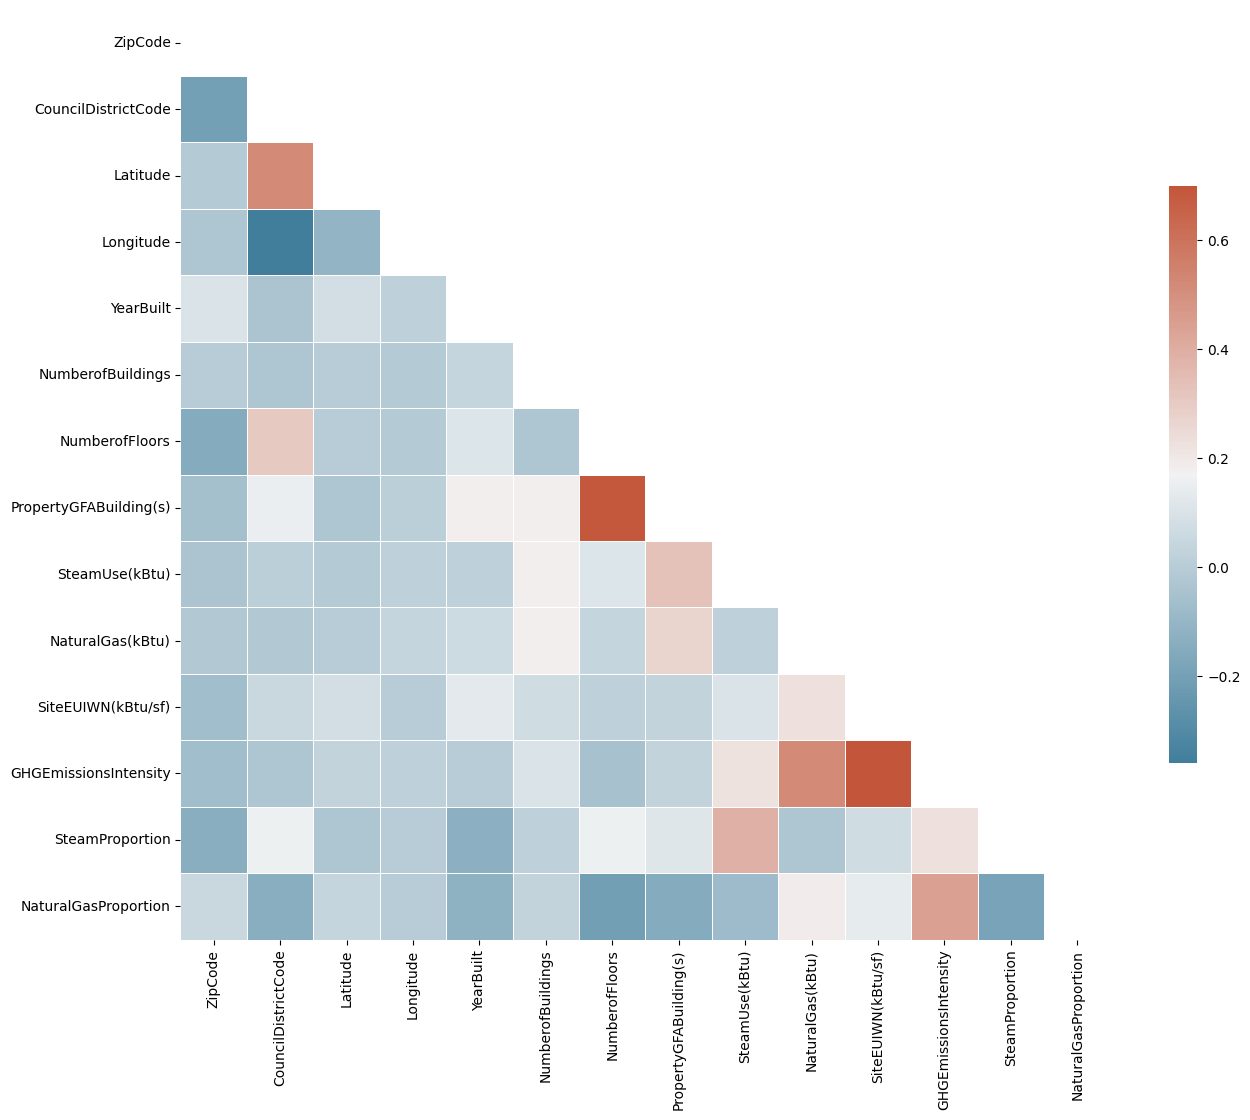

All analysis have been performed.


In [27]:
print("Starting the explanatory script.\n")
# remove_last_run_analysis_plots()

dataframe: DataFrame = load_and_filter_data()
print("The dataset has been loaded and filtered. Let's clean the data.\n")

print(f"Dataset size before cleaning and preparation:{len(dataframe)}\n")
dataframe = prepare_data(dataframe)
print(f"Dataset size after cleaning and preparation:{len(dataframe)}\n")

print("Starting univariate analysis.\n")
perform_univariate_analysis(dataframe, prefix="univariate_analysis")

print("Starting ACP analysis.\n")
perform_acp_analysis(dataframe)

for target_column in [TARGET_COLUMN, TARGET_COLUMN2]:
    print(f"Starting bivariate analysis for the target column:{target_column}\n", )
    perform_bivariate_analysis(dataframe, target_column)

print("All analysis have been performed.")